In [1]:
import numpy as np
import pandas as pd

import json
import csv

import datetime
import matplotlib.pyplot as plt

from statsmodels.regression.linear_model import RegressionResults
import pytz
import statsmodels.api as sm
from statsmodels.formula.api import ols


import itertools
import json
import pickle
import string
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_curve
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from nltk.corpus import stopwords




# http://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html
# http://connor-johnson.com/2014/02/18/linear-regression-with-python/

/Users/nnguyen/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
filenames = ['ECE219_tweet_data/tweets_#gohawks.txt',
            'ECE219_tweet_data/tweets_#gopatriots.txt',
            'ECE219_tweet_data/tweets_#nfl.txt',
            'ECE219_tweet_data/tweets_#patriots.txt',
            'ECE219_tweet_data/tweets_#sb49.txt',
            'ECE219_tweet_data/tweets_#superbowl.txt'
            ]

output_filenames = ['Q1_2#gohawks.txt',
                    'Q1_2#gopatriots.txt',
                   'Q1_2#nfl.txt',
                   'Q1_2#patriots.txt',
                   'Q1_2#sb49.txt',
                   'Q1_2#superbowl.txt']

for i in range(len(filenames)):
    pst_tz = pytz.timezone('US/Pacific')
    
    with open(filenames[i], 'r') as reader:
        headers = [
                   'citation_date_raw',
                   'author_nick_names',
                   'tweets',
                   'retweets',
                   'followers',
                   'followers_max'
                  ]
        with open(output_filenames[i], 'w') as writer:
            csv_writer = csv.writer(writer, lineterminator='\n')
            csv_writer.writerow(headers)
            for line in reader:
                data = json.loads(line)
                response =  [
                            data['citation_date'],
                            data['author']['nick'],
                            1, # there is one tweet at a time..
                            data['metrics']['citations']['total'], #retweets
                            data['author']['followers'], #followers
                            data['author']['followers'], #followers
                             ]
                csv_writer.writerow(response)


In [43]:
def parse_date_pst(df):
    utc_tz = pytz.UTC
    pst_tz = pytz.timezone('America/Los_Angeles')
    df['citation_date'] = pd.to_datetime(df['citation_date_raw'], unit='s')
    df['citation_date_pst'] = pd.to_datetime(df['citation_date_raw'], unit='s').apply(lambda x: x.tz_localize(utc_tz).astimezone(pst_tz))
    df['date'] = df['citation_date_pst'].apply(lambda x: x.strftime('%Y%m%d'))
    df['hour'] = df['citation_date_pst'].apply(lambda x: x.hour)
    df['minute'] = df['citation_date_pst'].apply(lambda x: x.minute)
    
    
def get_basic_statistics(dataframe):
    max = dataframe.max()
    min = dataframe.min()
    avg_tweets_per_hour = dataframe['tweets'].sum() / ((max['citation_date_pst'] - min['citation_date_pst']).total_seconds() / 60 / 60)
    print('Average tweets per hour:',avg_tweets_per_hour)
    
    avg_followers_posting_tweets = dataframe['followers'].sum() / dataframe['tweets'].sum()
    print('Average number of users posting tweets per tweet:', avg_followers_posting_tweets)
    
    avg_retweet_per_tweet = dataframe['retweets'].sum() / dataframe['tweets'].sum()
    print('Average number of retweet per tweet:', avg_retweet_per_tweet)
    
       
# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())    
    
    
    
def train_ols(df_agg, title: 'Generic stuff...'):
    print('=============================',title,'======================================')

    #train ols here
    model = ols("future_tweets ~ tweets + hour + retweets + followers + followers_max", data=df_agg).fit()
    print(model.summary())
    print('==============================MSE==============================================')
    print("MSE_residual:",model.mse_resid)
    
    fig, ax = plt.subplots()
    fig = sm.graphics.plot_fit(model, "hour", ax=ax)
    plt.show()
    
    fig1, ax1 = plt.subplots()
    fig1 = sm.graphics.plot_fit(model, "tweets", ax=ax1)
    plt.show()
    
    fig2, ax2 = plt.subplots()
    fig2 = sm.graphics.plot_fit(model, "retweets", ax=ax2)
    plt.show()
    
    fig3, ax3 = plt.subplots()
    fig3 = sm.graphics.plot_fit(model, "followers", ax=ax3)
    plt.show()
    
    fig4, ax4 = plt.subplots()
    fig4 = sm.graphics.plot_fit(model, "followers_max", ax=ax4)
    plt.show()
    
    
#     fig = plt.figure(figsize=(12,8))
#     fig = sm.graphics.plot_partregress_grid(model, fig=fig)
#     plt.show()
    
#     hour_exog = plt.figure(figsize=(12,8))
#     hour_exog = sm.graphics.plot_regress_exog(model, "hour", fig=hour_exog)
#     plt.show()
    
#     retweets_exog = plt.figure(figsize=(12,8))
#     retweets_exog = sm.graphics.plot_regress_exog(model, "retweets", fig=retweets_exog)
#     plt.show()
    
#     followers_exog = plt.figure(figsize=(12,8))
#     followers_exog = sm.graphics.plot_regress_exog(model, "followers", fig=followers_exog)
#     plt.show()
    
#     followers_max_exog = plt.figure(figsize=(12,8))
#     followers_max_exog = sm.graphics.plot_regress_exog(model, "followers_max", fig=followers_max_exog)
#     plt.show()
    
    return model

    
    

In [28]:
# Some global variables to help the helper functions
table = str.maketrans({key: None for key in string.punctuation})
english_stopwords = stopwords.words('english')
for n,stopword in enumerate(english_stopwords):
    english_stopwords[n] = stopword.translate(table).lower()
english_stopwords = set(english_stopwords)

def clean_tweet(tweet):
    # Split by white space
    words = tweet.split()
    # Remove anything with "@", "t.co","&"
    for n,word in enumerate(words):
        if "@" in word or "t.co" in word:# or "&" in word:
            words[n] = ""
        else:
            # Remove punctuation and lowercase
            words[n] = word.translate(table).lower()
            # Check if clean word in clean stopword set
            if words[n] in english_stopwords or not words[n].isalnum():
                words[n] = ""
            
    clean_tweet = " ".join(filter(None,words))
    return clean_tweet

def print_metrics(truth,pred):
    print('Accuracy: ' + str(metrics.accuracy_score(truth, pred)))
    print('Precision: ' + str(metrics.precision_score(truth, pred)))
    print('Recall: ' + str(metrics.recall_score(truth, pred)))
    print('F-1 Score: ' + str(metrics.f1_score(truth, pred)))
    
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          classes = ['Massachussetts', 'Washington']
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def roc_plotter(model, data, labels, clfType):
    if clfType == "LogisticRegression":
        scores = model.decision_function(data)
    elif clfType in ["RandomForest","NaiveBayes"]:
        scores = model.predict_log_proba(data)[:,1]
    else:
        print("Invalid clfType.")
        return
    fpr, tpr, thresholds = roc_curve(labels,scores)
    plt.plot(fpr,tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [29]:
# QUESTION 1: Report the following statistics for each hashtag:
#  Average number of tweets per hour
#  Average number of followers of users posting the tweets per tweet (to make it simple, we
# average over the number of tweets; if a users posted twice, we count the user and the user's
# followers twice as well)
#  Average number of retweets per tweet

In [30]:
gohawks = pd.read_csv('Q1_2#gohawks.txt',delimiter=',')
gopatriots = pd.read_csv('Q1_2#gopatriots.txt',delimiter=',')
nfl = pd.read_csv('Q1_2#nfl.txt',delimiter=',')
patriots = pd.read_csv('Q1_2#patriots.txt',delimiter=',')
sb49 = pd.read_csv('Q1_2#sb49.txt',delimiter=',')
superbowl = pd.read_csv('Q1_2#superbowl.txt',delimiter=',')

In [31]:
# parse date for use down below.

parse_date_pst(gohawks)
parse_date_pst(gopatriots)
parse_date_pst(nfl)
parse_date_pst(patriots)
parse_date_pst(sb49)
parse_date_pst(superbowl)

In [32]:
# go hawks
print('GoHawks')
get_basic_statistics(gohawks)

#go patriots
print('GoPatriots')
get_basic_statistics(gopatriots)

print('NFL')
get_basic_statistics(nfl)

print('Patriots')
get_basic_statistics(patriots)

print('Sb49')
get_basic_statistics(sb49)

print('Superbowl')
get_basic_statistics(superbowl)

GoHawks
Average tweets per hour: 292.4878506217368
Average number of users posting tweets per tweet: 2217.9237355281984
Average number of retweet per tweet: 2.0132093991319877
GoPatriots
Average tweets per hour: 40.95469800606194
Average number of users posting tweets per tweet: 1427.2526051635405
Average number of retweet per tweet: 1.4081919101697078
NFL
Average tweets per hour: 397.0213901819841
Average number of users posting tweets per tweet: 4662.37544523693
Average number of retweet per tweet: 1.5344602655543254
Patriots
Average tweets per hour: 750.89426460689
Average number of users posting tweets per tweet: 3280.4635616550277
Average number of retweet per tweet: 1.7852871288476946
Sb49
Average tweets per hour: 1276.857059868047
Average number of users posting tweets per tweet: 10374.160292019487
Average number of retweet per tweet: 2.52713444111402
Superbowl
Average tweets per hour: 2072.1184017040796
Average number of users posting tweets per tweet: 8814.96799424623
Average 

In [14]:
# QUESTION 2: Plot "number of tweets in hour" over time for #SuperBowl and #NFL (a histogram
# with 1-hour bins). The tweets are stored in separate files for different hashtags and files are named
# as tweet [#hashtag].txt.

In [47]:
max = nfl.max()
min = nfl.min()
nfl['time_hour'] = nfl['citation_date'].apply(lambda x: round((x - min['citation_date']).total_seconds()/60/60))
nfl_time_hour = nfl.groupby('time_hour').sum()

nfl_x = list(nfl_time_hour.index)
nfl_y = list(nfl_time_hour.tweets)


In [48]:
print('=======min========')
print(min)
print('=======max========')
print(max)

=======min========
citation_date_raw                   1421222404
author_nick_names                      007mmi6
tweets                                       1
retweets                                     1
followers                                    0
followers_max                                0
citation_date              2015-01-14 08:00:04
citation_date_pst    2015-01-14 00:00:04-08:00
date                                  20150114
hour                                         0
minute                                       0
time_hour                                    0
dtype: object
=======max========
citation_date_raw                   1423335336
author_nick_names                   zzzzuuuppp
tweets                                       1
retweets                                  3856
followers                          9.62388e+06
followers_max                      9.62388e+06
citation_date              2015-02-07 18:55:36
citation_date_pst    2015-02-07 10:55:36-08:00
date    

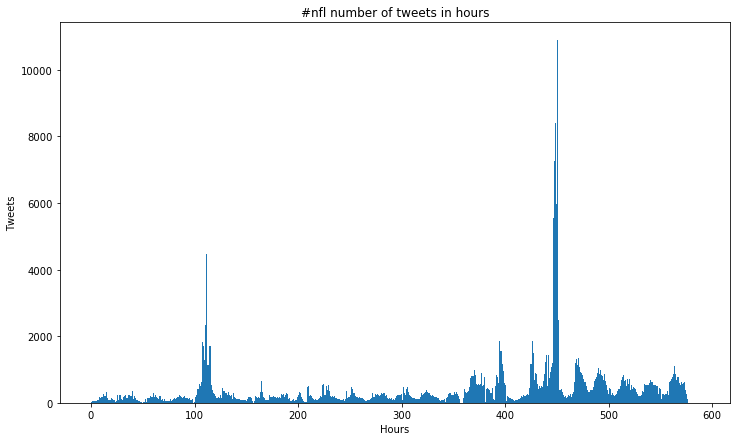

In [50]:
plt.figure(figsize=(12,7))
plt.bar(nfl_x, nfl_y, width=nfl_x[1]-nfl_x[0])
plt.xlabel('Hours')
plt.ylabel('Tweets')
plt.title('#nfl number of tweets in hours')
plt.show()

In [51]:
max = superbowl.max()
min = superbowl.min()
superbowl['time_hour'] = superbowl['citation_date'].apply(lambda x: round((x - min['citation_date']).total_seconds()/60/60))
superbowl_time_hour = superbowl.groupby('time_hour').sum()
superbowl_time_hour_x = list(superbowl_time_hour.index)
superbowl_time_hour_y = list(superbowl_time_hour.tweets)

In [52]:
print('=======min========')
print(min)
print('=======max========')
print(max)

=======min========
citation_date_raw             1421223187
tweets                                 1
retweets                               1
followers                              0
followers_max                          0
citation_date        2015-01-14 08:13:07
citation_date_pst    2015-01-14 08:13:07
date                            20150114
hour                                   0
minute                                 0
dtype: object
=======max========
citation_date_raw             1423332008
tweets                                 1
retweets                           17775
followers                    4.09023e+07
followers_max                4.09023e+07
citation_date        2015-02-07 18:00:08
citation_date_pst    2015-02-07 18:00:08
date                            20150207
hour                                  23
minute                                59
dtype: object


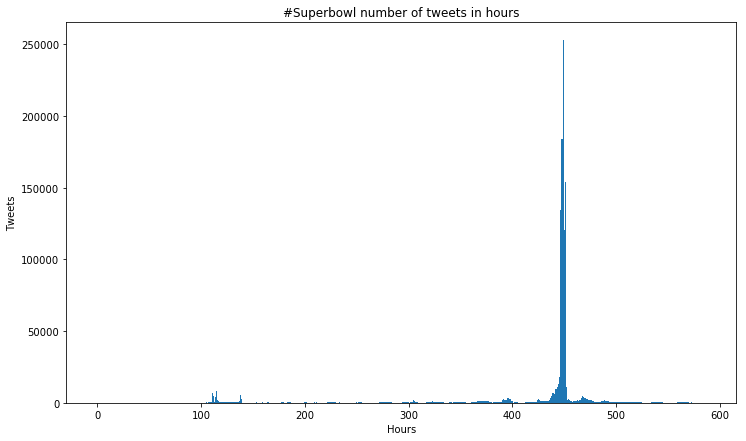

In [54]:
plt.figure(figsize=(12,7))
plt.bar(superbowl_time_hour_x, superbowl_time_hour_y, width=superbowl_time_hour_x[1]-superbowl_time_hour_x[0])
plt.xlabel('Hours')
plt.ylabel('Tweets')
plt.title('#Superbowl number of tweets in hours')
plt.show()

In [55]:
max = gohawks.max()
min = gohawks.min()
gohawks['time_hour'] = gohawks['citation_date'].apply(lambda x: round((x - min['citation_date']).total_seconds()/60/60))
gohawks_time_hour = gohawks.groupby('time_hour').sum()

gohawks_x = list(gohawks_time_hour.index)
gohawks_y = list(gohawks_time_hour.tweets)


In [56]:
print('=======min========')
print(min)
print('=======max========')
print(max)

=======min========
citation_date_raw                   1421222681
author_nick_names                      007mmi6
tweets                                       1
retweets                                     1
followers                                    0
followers_max                                0
citation_date              2015-01-14 08:04:41
citation_date_pst    2015-01-14 00:04:41-08:00
date                                  20150114
hour                                         0
minute                                       0
time_hour                                    0
dtype: object
=======max========
citation_date_raw                   1423304269
author_nick_names                     zzz_news
tweets                                       1
retweets                                 11516
followers                           4.7219e+06
followers_max                       4.7219e+06
citation_date              2015-02-07 10:17:49
citation_date_pst    2015-02-07 02:17:49-08:00
date    

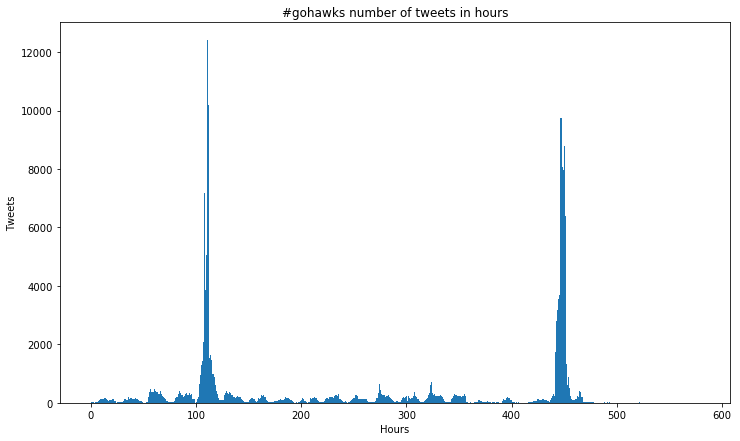

In [57]:
plt.figure(figsize=(12,7))
plt.bar(gohawks_x, gohawks_y, width=gohawks_x[1]-gohawks_x[0])
plt.xlabel('Hours')
plt.ylabel('Tweets')
plt.title('#gohawks number of tweets in hours')
plt.show()

In [58]:
max = gopatriots.max()
min = gopatriots.min()
gopatriots['time_hour'] = gopatriots['citation_date'].apply(lambda x: round((x - min['citation_date']).total_seconds()/60/60))
gopatriots_time_hour = gopatriots.groupby('time_hour').sum()

gopatriots_x = list(gopatriots_time_hour.index)
gopatriots_y = list(gopatriots_time_hour.tweets)


In [59]:
print('=======min========')
print(min)
print('=======max========')
print(max)

=======min========
citation_date_raw                   1421229011
author_nick_names              007richardadams
tweets                                       1
retweets                                     1
followers                                    0
followers_max                                0
citation_date              2015-01-14 09:50:11
citation_date_pst    2015-01-14 01:50:11-08:00
date                                  20150114
hour                                         0
minute                                       0
time_hour                                    0
dtype: object
=======max========
citation_date_raw                   1423295675
author_nick_names                  zzzzzxx1231
tweets                                       1
retweets                                   379
followers                          3.07701e+06
followers_max                      3.07701e+06
citation_date              2015-02-07 07:54:35
citation_date_pst    2015-02-06 23:54:35-08:00
date    

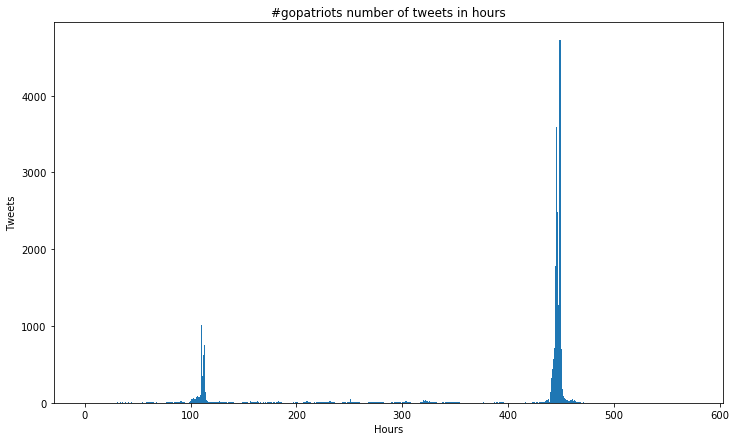

In [60]:
plt.figure(figsize=(12,7))
plt.bar(gopatriots_x, gopatriots_y, width=gopatriots_x[1]-gopatriots_x[0])
plt.xlabel('Hours')
plt.ylabel('Tweets')
plt.title('#gopatriots number of tweets in hours')
plt.show()

In [ ]:
len(gohawks.author_nick_names.unique())

In [ ]:
len(gopatriots.author_nick_names.unique())

In [22]:
# QUESTION 3: For each of your models, report your model's Mean Squared Error (MSE) and
# R-squared measure. Also, analyse the significance of each feature using the t-test and p-value. You
# may use the OLS in the libarary statsmodels in Python.



============================= Gohawks aggregated ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     100.9
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           1.20e-75
Time:                        22:43:31   Log-Likelihood:                -4609.7
No. Observations:                 562   AIC:                             9231.
Df Residuals:                     556   BIC:                             9257.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

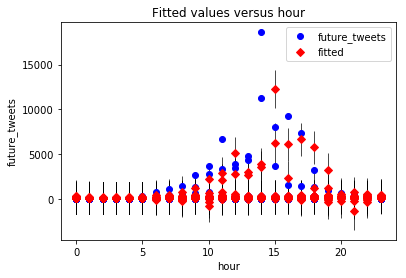

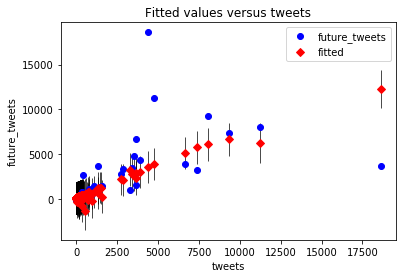

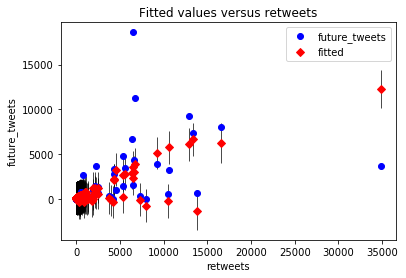

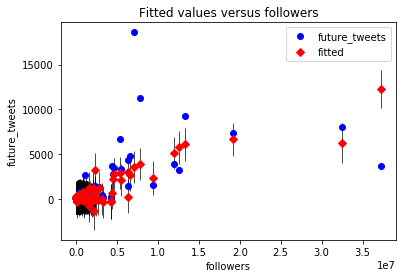

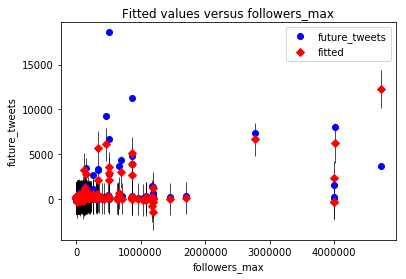

In [44]:
gohawks_agg = gohawks.groupby(pd.Grouper(key='citation_date_pst',freq='60Min')).agg({
    'hour':'max',
    'tweets':'sum',
    'retweets':'sum',
    'followers':'sum',
    'followers_max':'max'
})
gohawks_agg['future_tweets'] = gohawks_agg['tweets']
gohawks_agg.future_tweets = gohawks_agg.future_tweets.shift(-1)
gohawks_model = train_ols(gohawks_agg, 'Gohawks aggregated')

============================= GoPatriots aggregated ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     128.8
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           6.50e-80
Time:                        22:47:36   Log-Likelihood:                -2628.7
No. Observations:                 391   AIC:                             5269.
Df Residuals:                     385   BIC:                             5293.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

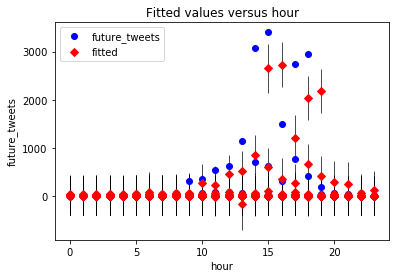

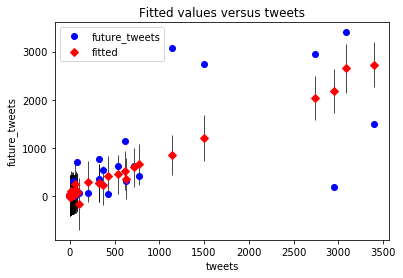

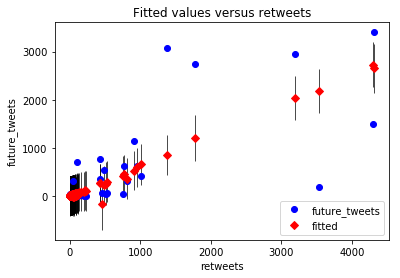

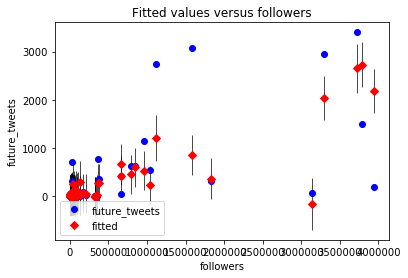

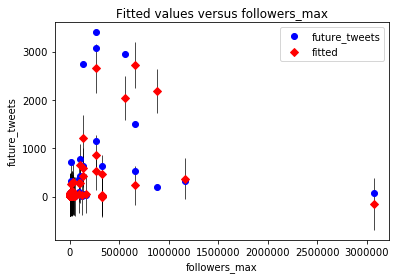

In [45]:
gopatriots_agg = gopatriots.groupby(pd.Grouper(key='citation_date_pst',freq='60Min')).agg({
    'hour':'max',
    'tweets':'sum',
    'retweets':'sum',
    'followers':'sum',
    'followers_max':'max'
})
gopatriots_agg['future_tweets'] = gopatriots_agg['tweets']
gopatriots_agg.future_tweets = gopatriots_agg.future_tweets.shift(-1)
gopatriots_model = train_ols(gopatriots_agg, 'GoPatriots aggregated')

============================= nlf aggregated ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     151.5
Date:                Tue, 05 Jun 2018   Prob (F-statistic):          2.80e-102
Time:                        22:47:37   Log-Likelihood:                -4438.1
No. Observations:                 578   AIC:                             8888.
Df Residuals:                     572   BIC:                             8914.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

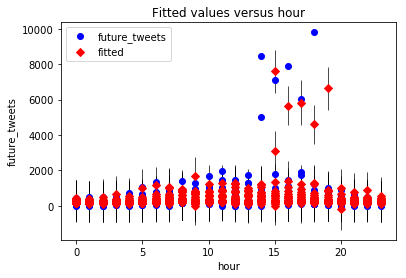

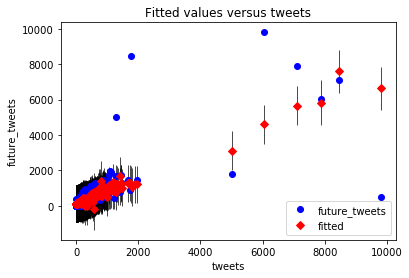

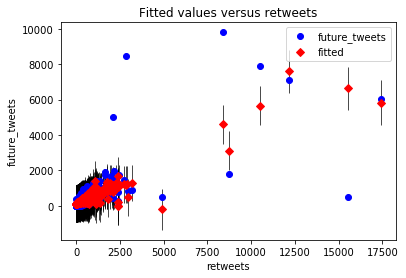

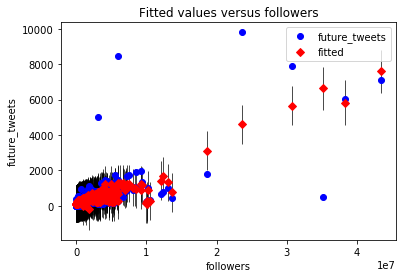

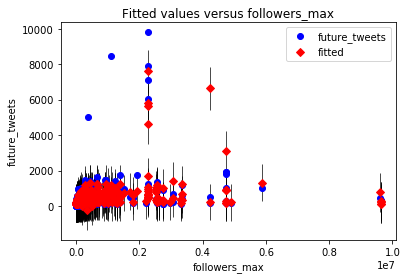

In [46]:
nfl_agg = nfl.groupby(pd.Grouper(key='citation_date_pst',freq='60Min')).agg({
    'hour':'max',
    'tweets':'sum',
    'retweets':'sum',
    'followers':'sum',
    'followers_max':'max'
})
nfl_agg['future_tweets'] = nfl_agg['tweets']
nfl_agg.future_tweets = nfl_agg.future_tweets.shift(-1)
nfl_model = train_ols(nfl_agg, 'nlf aggregated')

============================= patriots aggregated ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     233.8
Date:                Tue, 05 Jun 2018   Prob (F-statistic):          1.91e-136
Time:                        22:47:38   Log-Likelihood:                -5361.4
No. Observations:                 586   AIC:                         1.073e+04
Df Residuals:                     580   BIC:                         1.076e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

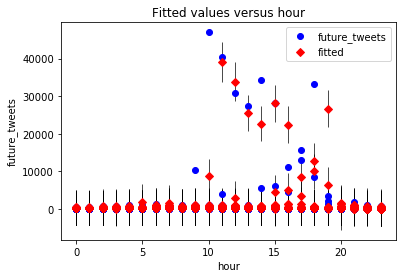

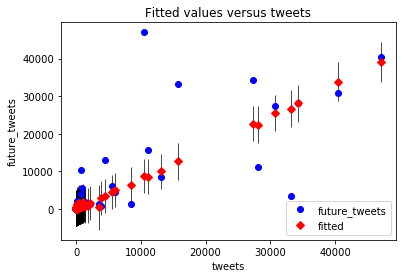

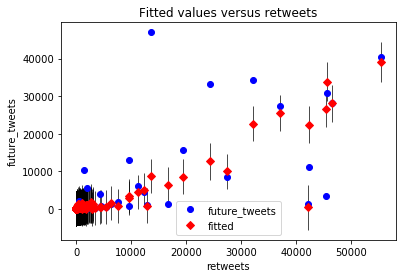

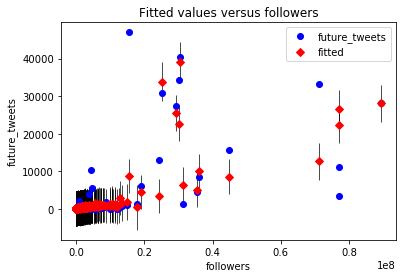

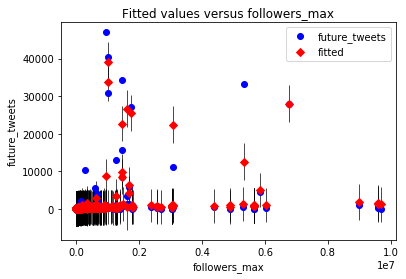

In [47]:
patriots_agg = patriots.groupby(pd.Grouper(key='citation_date_pst',freq='60Min')).agg({
    'hour':'max',
    'tweets':'sum',
    'retweets':'sum',
    'followers':'sum',
    'followers_max':'max'
})
patriots_agg['future_tweets'] = patriots_agg['tweets']
patriots_agg.future_tweets = patriots_agg.future_tweets.shift(-1)
patriots_model = train_ols(patriots_agg, 'patriots aggregated')

============================= sb49 aggregated ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     417.9
Date:                Tue, 05 Jun 2018   Prob (F-statistic):          1.44e-177
Time:                        22:47:40   Log-Likelihood:                -5036.7
No. Observations:                 515   AIC:                         1.009e+04
Df Residuals:                     509   BIC:                         1.011e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

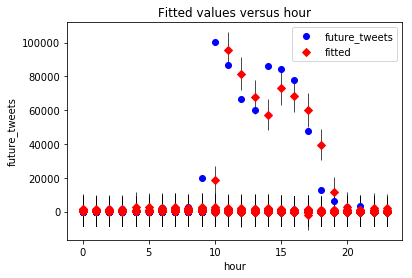

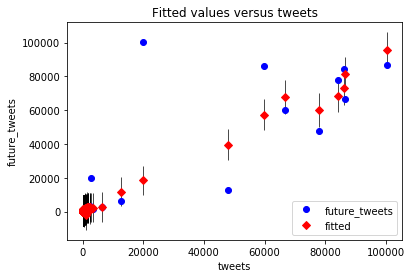

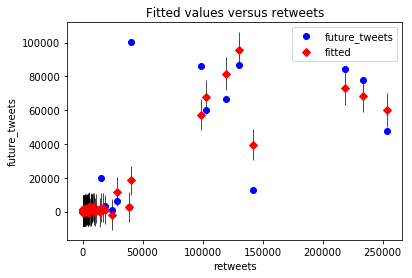

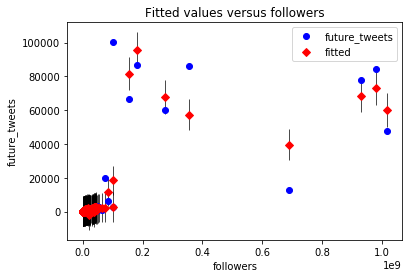

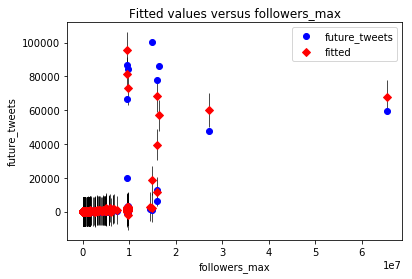

In [48]:
sb49_agg = sb49.groupby(pd.Grouper(key='citation_date_pst',freq='60Min')).agg({
    'hour':'max',
    'tweets':'sum',
    'retweets':'sum',
    'followers':'sum',
    'followers_max':'max'
})
sb49_agg['future_tweets'] = sb49_agg['tweets']
sb49_agg.future_tweets = sb49_agg.future_tweets.shift(-1)
sb49_model = train_ols(sb49_agg, 'sb49 aggregated')

============================= superbowl aggregated ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     463.5
Date:                Tue, 05 Jun 2018   Prob (F-statistic):          6.72e-200
Time:                        22:47:41   Log-Likelihood:                -6039.9
No. Observations:                 586   AIC:                         1.209e+04
Df Residuals:                     580   BIC:                         1.212e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

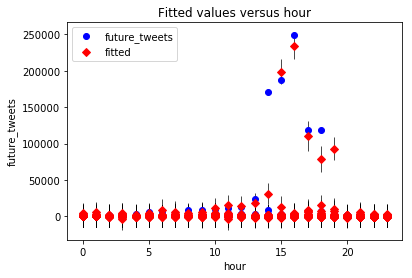

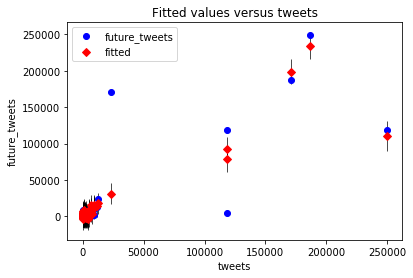

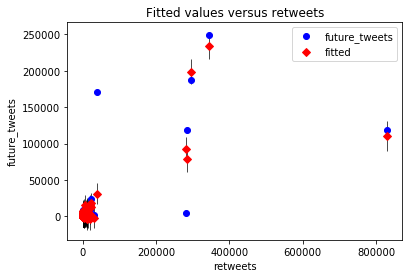

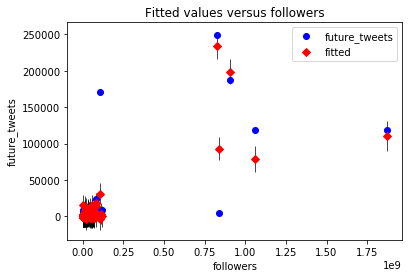

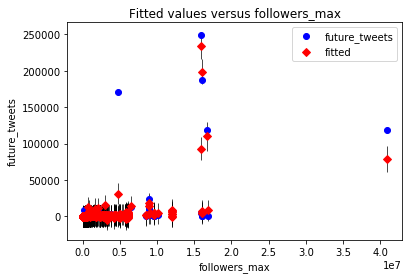

In [49]:
superbowl_agg = superbowl.groupby(pd.Grouper(key='citation_date_pst',freq='60Min')).agg({
    'hour':'max',
    'tweets':'sum',
    'retweets':'sum',
    'followers':'sum',
    'followers_max':'max'
})
superbowl_agg['future_tweets'] = superbowl_agg['tweets']
superbowl_agg.future_tweets = superbowl_agg.future_tweets.shift(-1)
superbowl_model = train_ols(superbowl_agg, 'superbowl aggregated')

In [29]:
# QUESTION 4: Design a regression model using any features from the papers you find or other
# new features you may find useful for this problem. Fit your model on the data of each hashtag and
# report fitting MSE and significance of features.

In [4]:
feature_filenames = ['ECE219_tweet_data/tweets_#gohawks.txt',
            'ECE219_tweet_data/tweets_#gopatriots.txt',
            'ECE219_tweet_data/tweets_#nfl.txt',
            'ECE219_tweet_data/tweets_#patriots.txt',
            'ECE219_tweet_data/tweets_#sb49.txt',
            'ECE219_tweet_data/tweets_#superbowl.txt'
            ]

feature_output_filenames = ['Q1_4#gohawks.txt',
                   'Q1_4#gopatriots.txt',
                   'Q1_4#nfl.txt',
                   'Q1_4#patriots.txt',
                   'Q1_4#sb49.txt',
                   'Q1_4#superbowl.txt']

for i in range(len(feature_filenames)):
    pst_tz = pytz.timezone('US/Pacific')
    
    with open(feature_filenames[i], 'r') as reader:
        feature_headers = [
                   'citation_date_raw',
                   'author_nick_names',
                   'tweets',
                   'retweets',
                   'urls',
                   'mentions',
                   'hashtags',
                   'followers',
                   'followers_max',
                  ]
        with open(feature_output_filenames[i], 'w') as writer:
            feature_csv_writer = csv.writer(writer, lineterminator='\n')
            feature_csv_writer.writerow(feature_headers)
            for line in reader:
                feature_data = json.loads(line)
                feature_response =  [
                            feature_data['citation_date'],
                            feature_data['author']['nick'],
                            1, # there is one tweet at a time..
                            feature_data['metrics']['citations']['total'], #retweets
                            len(feature_data['tweet']['entities']['urls']), #urls
                            len(feature_data['tweet']['entities']['user_mentions']), #mentions
                            len(feature_data['tweet']['entities']['hashtags']), #hashtags
                            feature_data['author']['followers'], #followers
                            feature_data['author']['followers'], #followers
                             ]
                feature_csv_writer.writerow(feature_response)

In [6]:
feature_gohawks = pd.read_csv('Q1_4#gohawks.txt',delimiter=',')
feature_gopatriots = pd.read_csv('Q1_4#gopatriots.txt',delimiter=',')
feature_nfl = pd.read_csv('Q1_4#nfl.txt',delimiter=',')
feature_patriots = pd.read_csv('Q1_4#patriots.txt',delimiter=',')
feature_sb49 = pd.read_csv('Q1_4#sb49.txt',delimiter=',')
feature_superbowl = pd.read_csv('Q1_4#superbowl.txt',delimiter=',')

In [7]:
parse_date_pst(feature_gohawks)
parse_date_pst(feature_gopatriots)
parse_date_pst(feature_nfl)
parse_date_pst(feature_patriots)
parse_date_pst(feature_sb49)
parse_date_pst(feature_superbowl)

In [9]:
feature_gohawks.head()

,citation_date_raw,author_nick_names,tweets,retweets,urls,mentions,hashtags,followers,followers_max,citation_date,citation_date_pst,date,hour,minute
0,1421518778,rejinseattle,1,5,0,0,1,1752.0,1752.0,2015-01-17 18:19:38,2015-01-17 10:19:38-08:00,20150117,10,19
1,1421259536,emq4444,1,2,0,0,2,258.0,258.0,2015-01-14 18:18:56,2015-01-14 10:18:56-08:00,20150114,10,18
2,1421468519,beccadelgado67,1,5,0,0,3,22.0,22.0,2015-01-17 04:21:59,2015-01-16 20:21:59-08:00,20150116,20,21
3,1421468497,beccadelgado67,1,2,1,0,7,22.0,22.0,2015-01-17 04:21:37,2015-01-16 20:21:37-08:00,20150116,20,21
4,1421468336,beccadelgado67,1,2,0,0,1,22.0,22.0,2015-01-17 04:18:56,2015-01-16 20:18:56-08:00,20150116,20,18


In [10]:
def group_features(df):
    df_agg = df.groupby(pd.Grouper(key='citation_date_pst',freq='60Min')).agg({
        'hour':'max',
        'tweets':'sum',
        'retweets':'sum',
        'urls':'sum',
        'mentions':'sum',
        'hashtags':'sum',
        'followers':'sum',
        'followers_max':'max'
    })
    
    return df_agg

In [11]:
feature_gohawks_agg = group_features(feature_gohawks)
feature_gopatriots_agg = group_features(feature_gopatriots)
feature_nfl_agg = group_features(feature_nfl)
feature_patriots_agg = group_features(feature_patriots)
feature_sb49_agg = group_features(feature_sb49)
feature_superbowl_agg = group_features(feature_superbowl)

In [12]:
feature_gohawks_agg.head()

,hour,tweets,retweets,urls,mentions,hashtags,followers,followers_max
citation_date_pst,,,,,,,,
2015-01-14 00:00:00-08:00,0.0,29.0,459.0,11.0,25.0,62.0,23814.0,12922.0
2015-01-14 01:00:00-08:00,1.0,13.0,32.0,4.0,10.0,39.0,7774.0,2592.0
2015-01-14 02:00:00-08:00,2.0,14.0,378.0,8.0,7.0,49.0,26891.0,11886.0
2015-01-14 03:00:00-08:00,3.0,9.0,28.0,3.0,8.0,23.0,19094.0,11886.0
2015-01-14 04:00:00-08:00,4.0,24.0,62.0,5.0,28.0,50.0,31949.0,9772.0


In [13]:
def significant_features(model, f):
    sig_features = {}
    pval = []
    for i in range(1,len(f)+1):
        pval.append(model.pvalues[i])
    
    for i in range(len(pval)):
        min_val = np.min(pval)
        min_feat = f[pval.index(np.min(pval))]
        sig_features[min_feat] = min_val
        pval.remove(min_val)
        f.remove(min_feat)
    print("Features used and their p-value significance: ", sig_features)
    return sig_features

In [14]:
def regression_model(df, name):
    print("\n=============================" +  name + "=============================")
    df['future_tweets'] = df['tweets']
    df.future_tweets = df.future_tweets.shift(-1)
    model = ols("future_tweets ~ tweets + hour + retweets + urls + mentions + hashtags + followers + followers_max", data=df).fit()
    features = ['tweets', 'hour', 'retweets', 'urls', 'mentions', 'hashtags', 'followers', 'followers_max']
    print("MSE_residual:",model.mse_resid)
    features = significant_features(model, features)
    ypred = model.predict(df)
    return features, ypred

In [23]:

top_features_gohawks_agg, gohawks_pred = regression_model(feature_gohawks_agg, "#gohawks")
top_features_gopatriots_agg, gopatriots_pred = regression_model(feature_gopatriots_agg, "#gopatriots")
top_features_nfl_agg, nfl_pred = regression_model(feature_nfl_agg, "#nfl")
top_features_patriots_agg, patriots_pred = regression_model(feature_patriots_agg, "#patriots")
top_features_sb49_agg, sb49_pred = regression_model(feature_sb49_agg, "#sb49")
top_features_superbowl_agg, superbowl_pred = regression_model(feature_superbowl_agg, "#superbowl")


=============================#gohawks=============================
MSE_residual: 647909.550952
Features used and their p-value significance:  {'followers': 1.014546169653817e-06, 'hashtags': 0.0018126797251780467, 'urls': 0.013595654514732642, 'mentions': 0.031559785135780283, 'followers_max': 0.076854608982355327, 'tweets': 0.26000627823212896, 'retweets': 0.41172093937316767, 'hour': 0.80335322227063832}

=============================#gopatriots=============================
MSE_residual: 26565.9619163
Features used and their p-value significance:  {'mentions': 1.9869707943125166e-13, 'retweets': 1.345793327596034e-05, 'urls': 0.00069179429129231777, 'followers_max': 0.33370069849760886, 'followers': 0.48623687306655095, 'tweets': 0.53854327087447884, 'hashtags': 0.72219712754553445, 'hour': 0.8428378475410353}

=============================#nfl=============================
MSE_residual: 205175.326466
Features used and their p-value significance:  {'hashtags': 1.3867598605977151e-31,

In [30]:
# QUESTION 5: For each of the top 3 features (i.e. with the smallest p-values) in your mea-
# surements, draw a scatter plot of predictant (number of tweets for next hour) versus value of that
# feature, using all the samples you have extracted, and analyze it.
# Do the regression coefficients agree with the trends in the plots? If not, why?

In [19]:
def scatter_plotter(x, y, name):
    plt.plot(x, y, 'o')

    plt.title(name)
    plt.xlabel('Predicted Number of Tweets for Next Hour')
    plt.ylabel('Value of ' + name)
    plt.show()
    return

In [20]:
def top_three_features(f, name, pred, df):
    print("\n\n=============================" + name + "=============================")
    top_f = {k: f[k] for k in list(f)[:3]}
    for key in top_f.keys():
        scatter_plotter(list(pred), list(df[key]), key)
    return



=============================#gohawks=============================


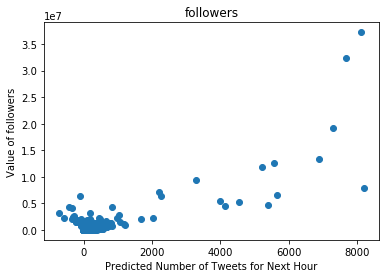

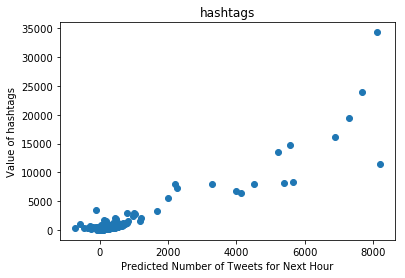

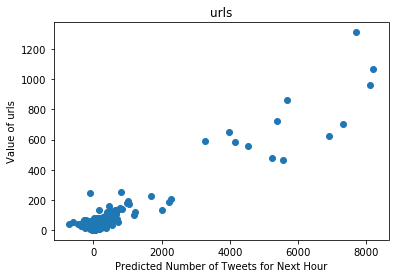



=============================#gopatriots=============================


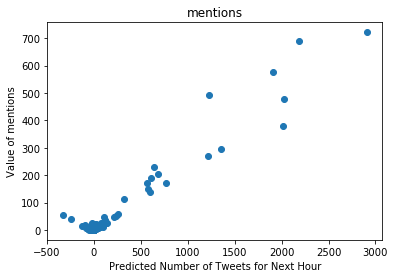

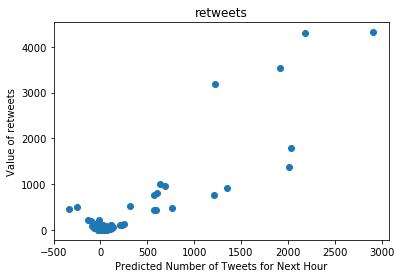

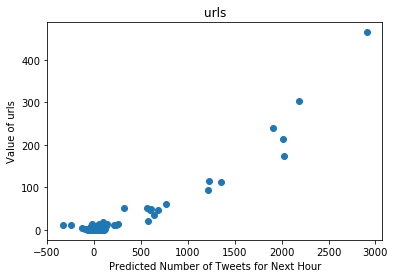



=============================#nfl=============================


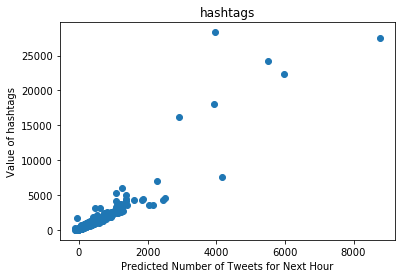

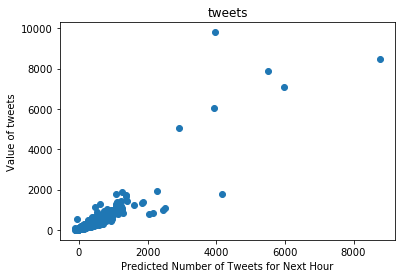

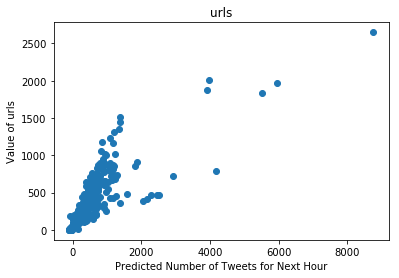



=============================#patriots=============================


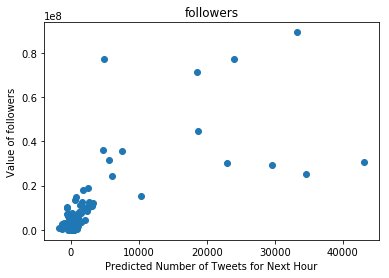

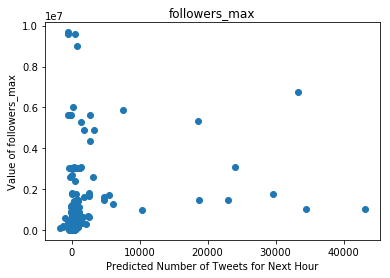

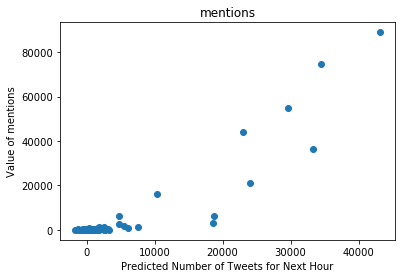



=============================#sb49=============================


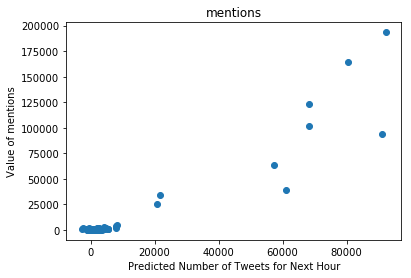

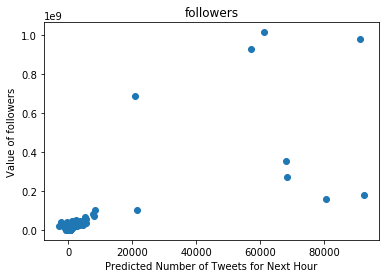

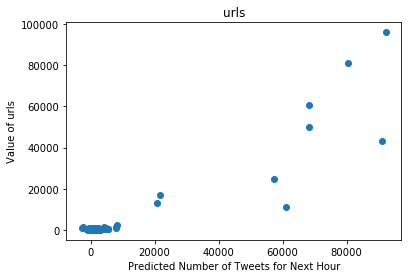



=============================#superbowl=============================


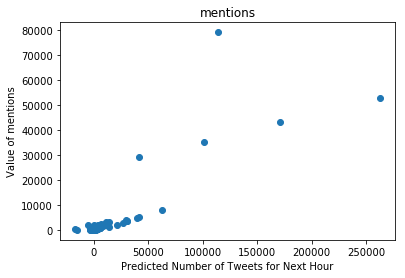

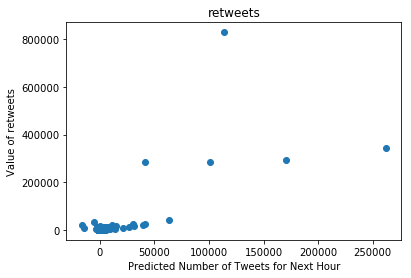

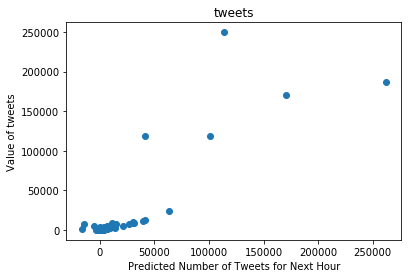

In [24]:
top_three_gohawks = top_three_features(top_features_gohawks_agg, "#gohawks", gohawks_pred, feature_gohawks_agg)
top_three_gopatriots = top_three_features(top_features_gopatriots_agg, "#gopatriots", gopatriots_pred, feature_gopatriots_agg)
top_three_nfl = top_three_features(top_features_nfl_agg, "#nfl", nfl_pred, feature_nfl_agg)
top_three_patriots = top_three_features(top_features_patriots_agg, "#patriots", patriots_pred, feature_patriots_agg)
top_three_sb49 = top_three_features(top_features_sb49_agg, "#sb49", sb49_pred, feature_sb49_agg)
top_three_superbowl = top_three_features(top_features_superbowl_agg, "#superbowl", superbowl_pred, feature_superbowl_agg)

In [ ]:
# QUESTION 6: We define three time periods and their corresponding window length as follows:
# 1. Before Feb. 1, 8:00 a.m.: 1-hour window
# 2. Between Feb. 1, 8:00 a.m. and 8:00 p.m.: 5-minute window
# 3. After Feb. 1, 8:00 p.m.: 1-hour window
# For each hashtag, train 3 regression models, one for each of these time periods (the times are all in
# PST). Report the MSE and R-squared score for each case.

In [50]:
def split_three_time_periods_and_train_ols(df,title='Generic'):
    df_pre_active_agg = df[df['citation_date_pst'] < '2015-02-01 08:00:00-0800'].groupby(pd.Grouper(key='citation_date_pst',
                                                                                               freq='60Min')).agg(
        {'hour':'max',
         'tweets':'sum',
         'retweets':'sum',
         'followers':'sum',
         'followers_max':'max'})
    #shifting tweets
    df_pre_active_agg['future_tweets'] = df_pre_active_agg['tweets']
    df_pre_active_agg.future_tweets = df_pre_active_agg.future_tweets.shift(-1)
    df_pre_active_model = train_ols(df_pre_active_agg, title + ' Before Feb. 1, 8:00 a.m.: 1-hour window')
    
    df_active_agg = df[(df['citation_date_pst'] >= '2015-02-01 08:00:00-0800') &
                       (df['citation_date_pst'] <= '2015-02-01 20:00:00-0800')].groupby(pd.Grouper(key='citation_date_pst',
                                                                                           freq='5Min')).agg(
        {'hour':'max',
         'tweets':'sum',
         'retweets':'sum',
         'followers':'sum',
         'followers_max':'max'})
    df_active_agg['future_tweets'] = df_active_agg['tweets']
    df_active_agg.future_tweets = df_active_agg.future_tweets.shift(-1)
    df_active_model = train_ols(df_active_agg, title + ' Between Feb. 1, 8:00 a.m. and 8:00 p.m.: 5-minute window')
    
    df_post_active_agg = df[df['citation_date_pst'] > '2015-02-01 20:00:00-0800'].groupby(pd.Grouper(key='citation_date_pst',
                                                                                           freq='60Min')).agg(
        {'hour':'max',
         'tweets':'sum',
         'retweets':'sum',
         'followers':'sum',
         'followers_max':'max'})
    df_post_active_agg['future_tweets'] = df_post_active_agg['tweets']
    df_post_active_agg.future_tweets = df_post_active_agg.future_tweets.shift(-1)
    df_post_active_model = train_ols(df_post_active_agg, title + ' After Feb. 1, 8:00 p.m.: 1-hour window')
          
    return df_pre_active_model, df_active_model, df_post_active_model, df_pre_active_agg, df_active_agg, df_post_active_agg


============================= Gohawks Before Feb. 1, 8:00 a.m.: 1-hour window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     37.70
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           4.29e-32
Time:                        22:48:04   Log-Likelihood:                -3582.8
No. Observations:                 439   AIC:                             7178.
Df Residuals:                     433   BIC:                             7202.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------

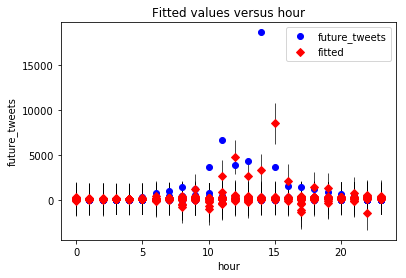

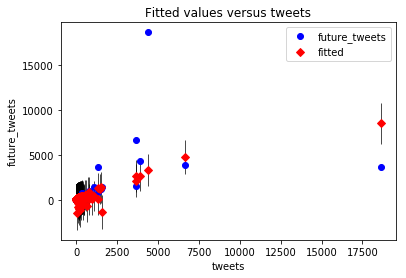

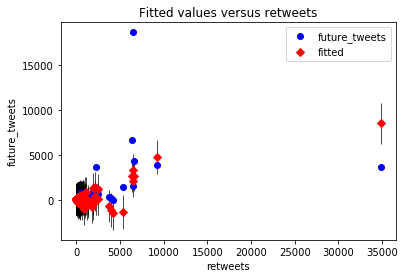

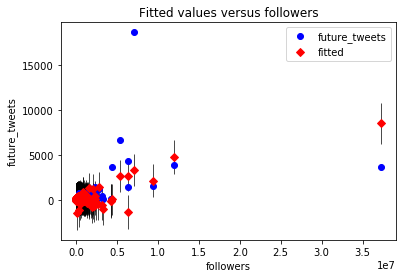

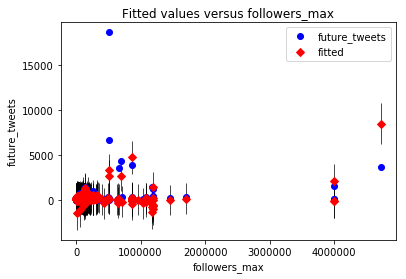

============================= Gohawks Between Feb. 1, 8:00 a.m. and 8:00 p.m.: 5-minute window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     26.77
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           8.21e-19
Time:                        22:48:05   Log-Likelihood:                -1002.4
No. Observations:                 143   AIC:                             2017.
Df Residuals:                     137   BIC:                             2034.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0

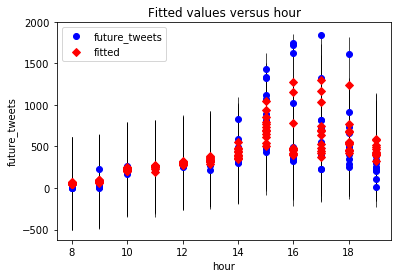

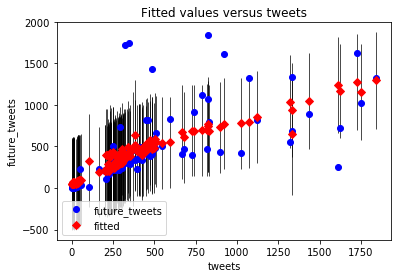

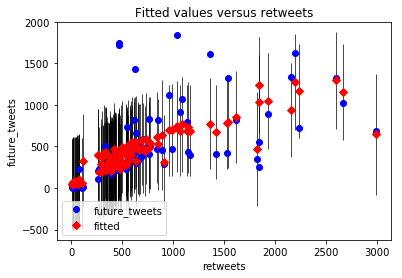

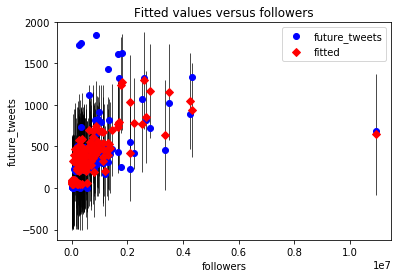

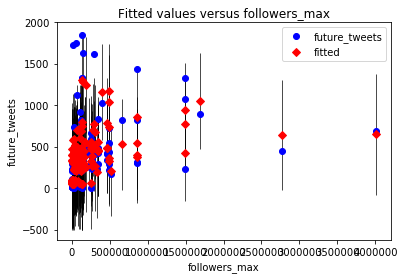

============================= Gohawks After Feb. 1, 8:00 p.m.: 1-hour window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     102.9
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           1.21e-38
Time:                        22:48:06   Log-Likelihood:                -576.74
No. Observations:                 110   AIC:                             1165.
Df Residuals:                     104   BIC:                             1182.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------

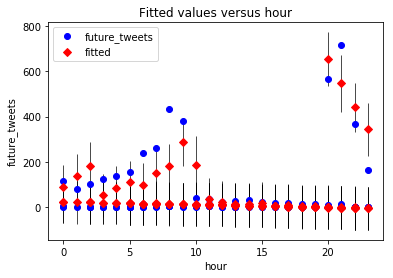

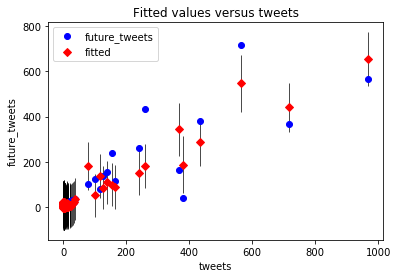

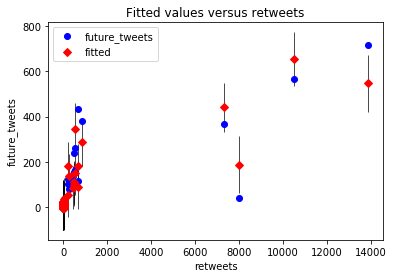

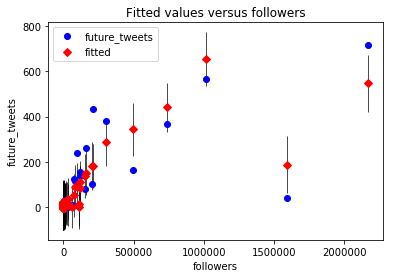

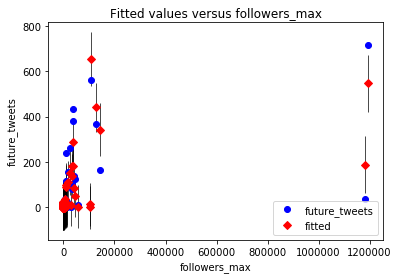

In [51]:
gohawks_pre_active, gohawks_active, gohawks_post_active, gohawks_pre_active_agg, gohawks_active_agg, gohawks_post_active_agg = split_three_time_periods_and_train_ols(gohawks,title='Gohawks')

============================= GoPatriots Before Feb. 1, 8:00 a.m.: 1-hour window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     90.56
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           1.74e-60
Time:                        22:48:07   Log-Likelihood:                -1832.8
No. Observations:                 348   AIC:                             3678.
Df Residuals:                     342   BIC:                             3701.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------

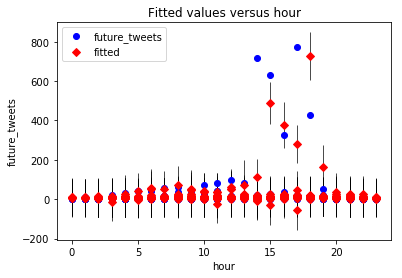

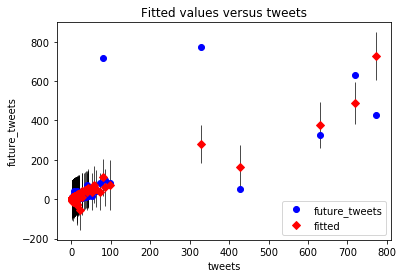

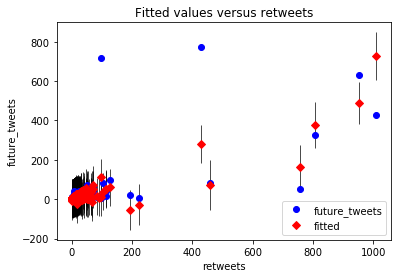

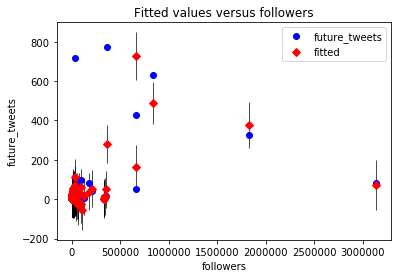

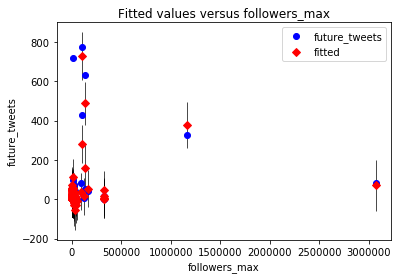

============================= GoPatriots Between Feb. 1, 8:00 a.m. and 8:00 p.m.: 5-minute window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     21.73
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           1.05e-15
Time:                        22:48:08   Log-Likelihood:                -831.22
No. Observations:                 134   AIC:                             1674.
Df Residuals:                     128   BIC:                             1692.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025    

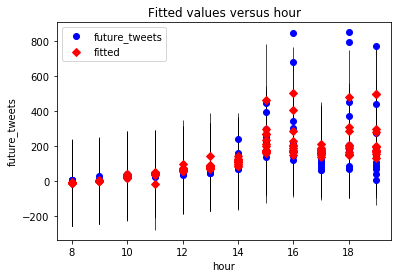

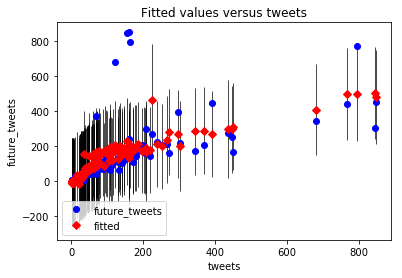

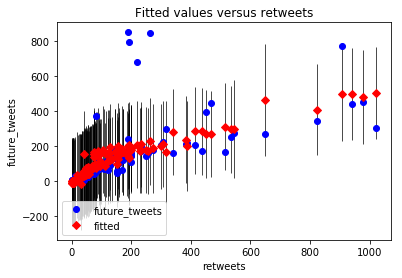

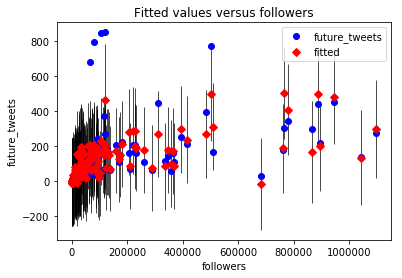

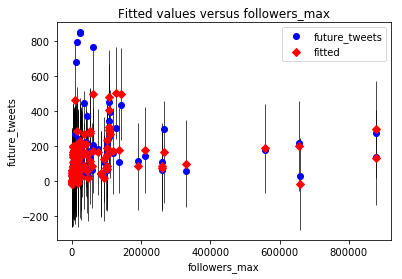

============================= GoPatriots After Feb. 1, 8:00 p.m.: 1-hour window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     8.812
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           7.43e-05
Time:                        22:48:09   Log-Likelihood:                -117.86
No. Observations:                  30   AIC:                             247.7
Df Residuals:                      24   BIC:                             256.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------

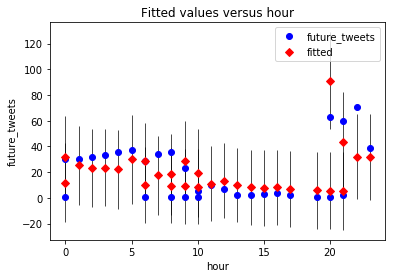

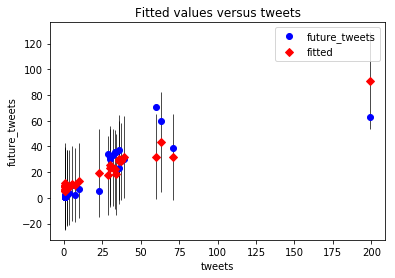

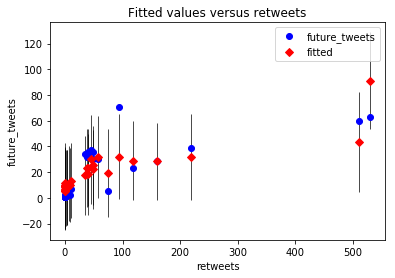

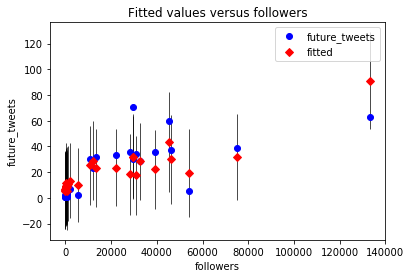

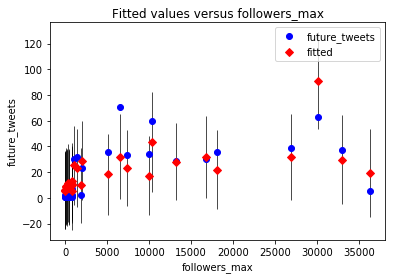

In [52]:
gopatriots_pre_active, gopatriots_active, gopatriots_post_active, gopatriots_pre_active_agg, gopatriots_active_agg, gopatriots_post_active_agg = split_three_time_periods_and_train_ols(gopatriots,title='GoPatriots')

============================= NFL Before Feb. 1, 8:00 a.m.: 1-hour window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     90.75
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           3.55e-65
Time:                        22:48:10   Log-Likelihood:                -3058.5
No. Observations:                 439   AIC:                             6129.
Df Residuals:                     433   BIC:                             6154.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------

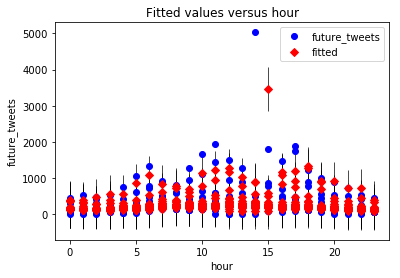

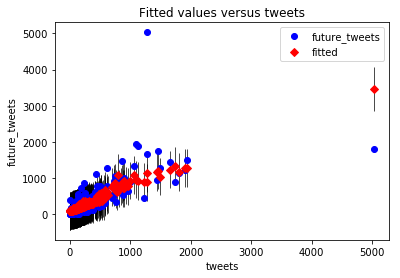

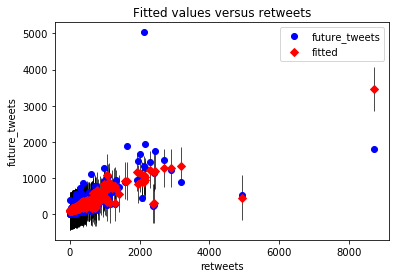

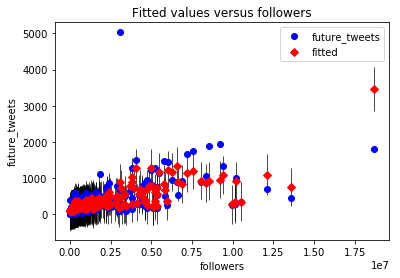

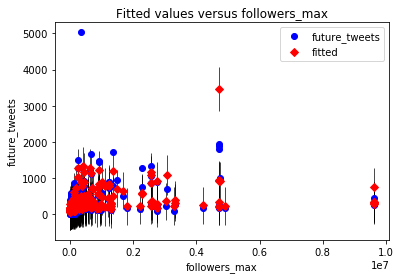

============================= NFL Between Feb. 1, 8:00 a.m. and 8:00 p.m.: 5-minute window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     123.3
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           6.41e-49
Time:                        22:48:12   Log-Likelihood:                -914.53
No. Observations:                 143   AIC:                             1841.
Df Residuals:                     137   BIC:                             1859.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975

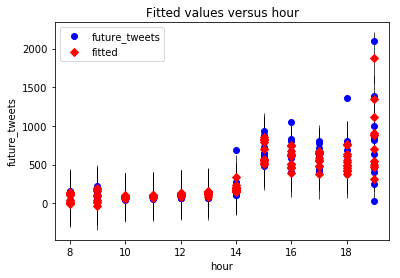

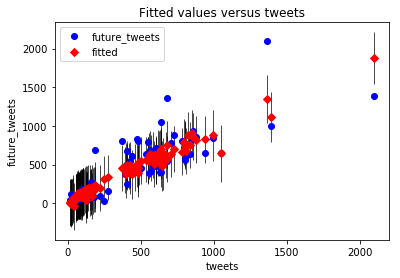

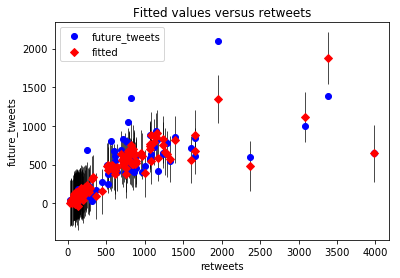

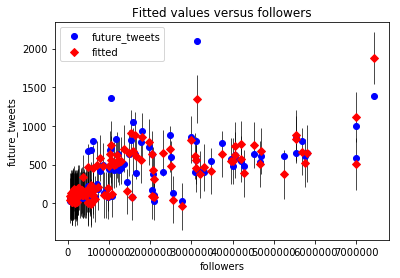

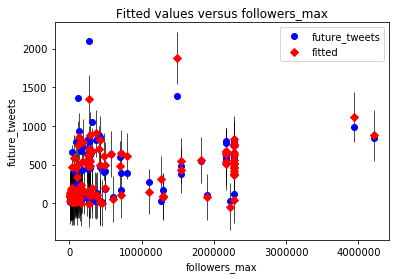

============================= NFL After Feb. 1, 8:00 p.m.: 1-hour window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     81.47
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           6.55e-37
Time:                        22:48:13   Log-Likelihood:                -793.20
No. Observations:                 126   AIC:                             1598.
Df Residuals:                     120   BIC:                             1615.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------

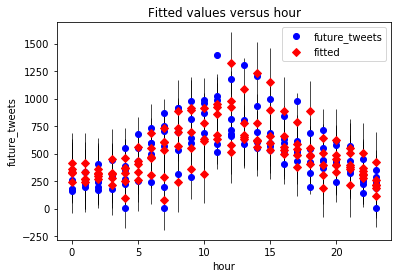

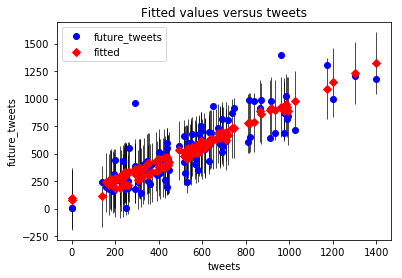

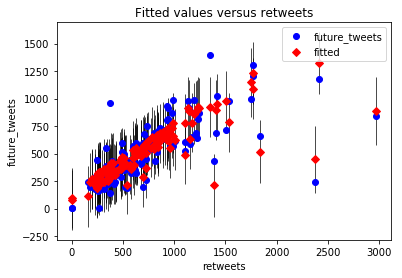

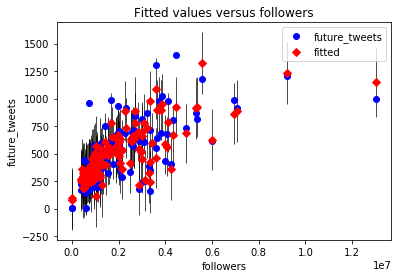

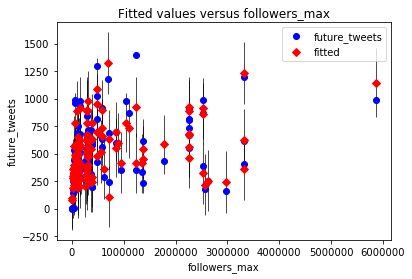

In [53]:
nfl_pre_active, nfl_active, nfl_post_active, nfl_pre_active_agg, nfl_active_agg, nfl_post_active_agg = split_three_time_periods_and_train_ols(nfl,title='NFL')

============================= Patriots Before Feb. 1, 8:00 a.m.: 1-hour window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     113.5
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           1.91e-76
Time:                        22:48:14   Log-Likelihood:                -3417.4
No. Observations:                 439   AIC:                             6847.
Df Residuals:                     433   BIC:                             6871.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------

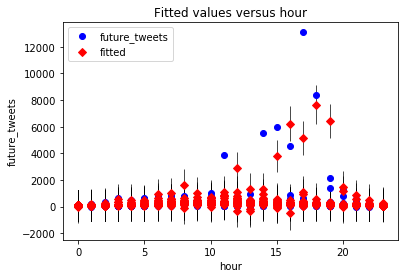

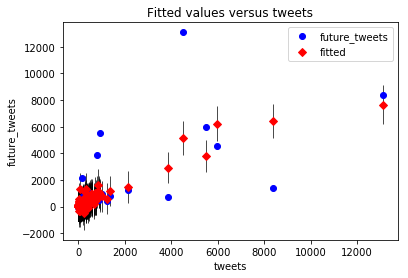

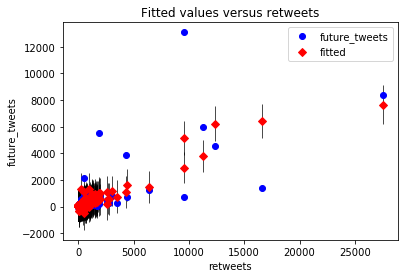

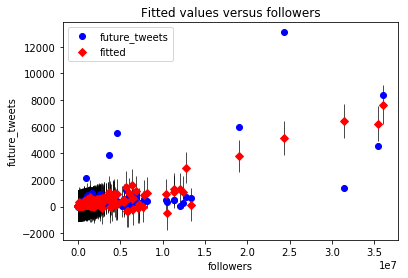

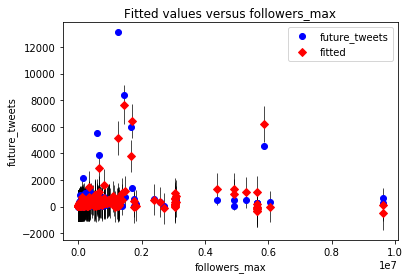

============================= Patriots Between Feb. 1, 8:00 a.m. and 8:00 p.m.: 5-minute window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     67.50
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           2.92e-35
Time:                        22:48:15   Log-Likelihood:                -1162.0
No. Observations:                 143   AIC:                             2336.
Df Residuals:                     137   BIC:                             2354.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      

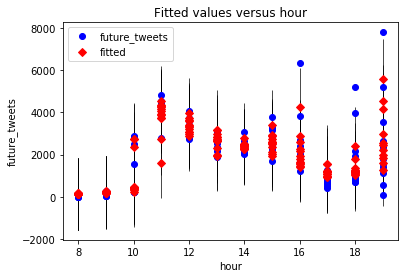

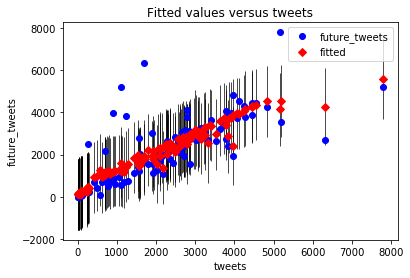

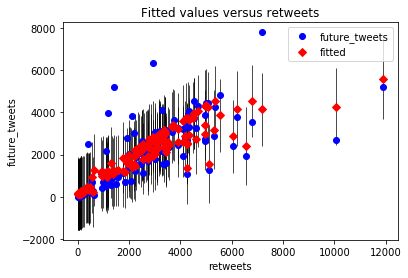

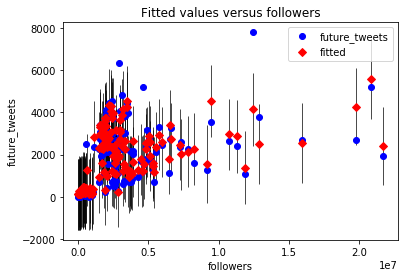

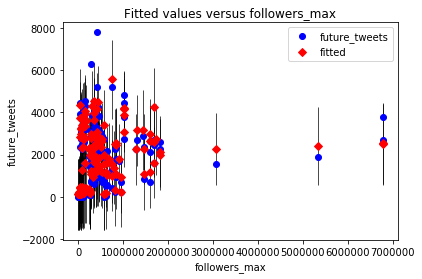

============================= Patriots After Feb. 1, 8:00 p.m.: 1-hour window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     181.3
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           2.72e-56
Time:                        22:48:16   Log-Likelihood:                -814.40
No. Observations:                 134   AIC:                             1641.
Df Residuals:                     128   BIC:                             1658.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------

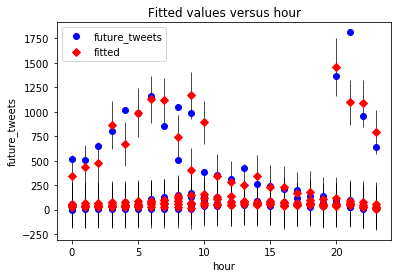

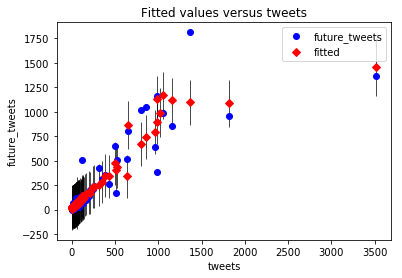

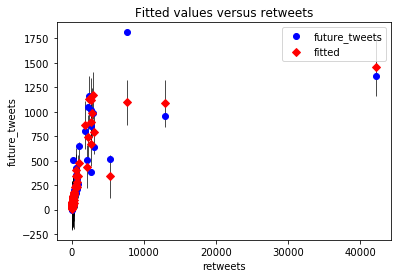

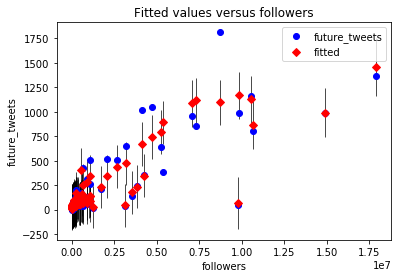

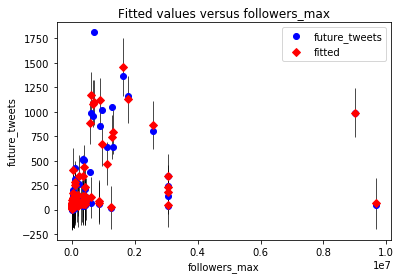

In [54]:
patriots_pre_active, patriots_active, patriots_post_active, patriots_pre_active_agg, patriots_active_agg, patriots_post_active_agg = split_three_time_periods_and_train_ols(patriots,title='Patriots')

============================= SB49 Before Feb. 1, 8:00 a.m.: 1-hour window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     461.3
Date:                Tue, 05 Jun 2018   Prob (F-statistic):          1.39e-154
Time:                        22:48:18   Log-Likelihood:                -2178.1
No. Observations:                 368   AIC:                             4368.
Df Residuals:                     362   BIC:                             4392.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------

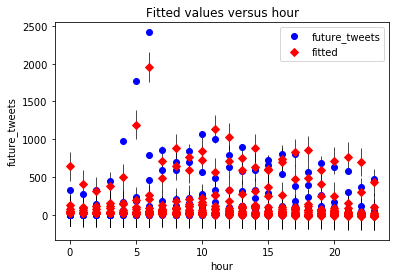

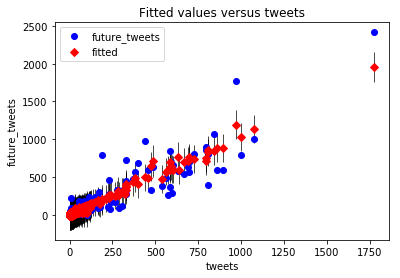

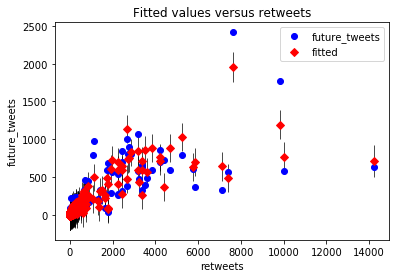

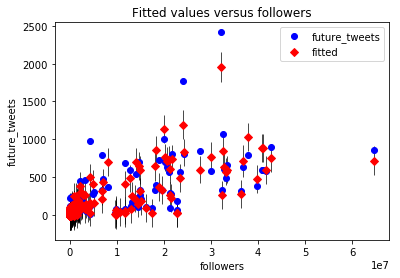

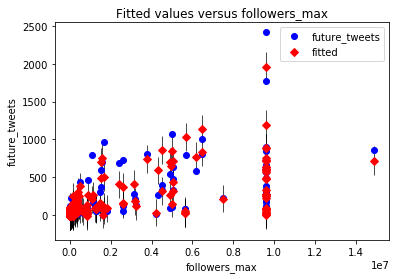

============================= SB49 Between Feb. 1, 8:00 a.m. and 8:00 p.m.: 5-minute window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     172.8
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           2.38e-57
Time:                        22:48:19   Log-Likelihood:                -1210.3
No. Observations:                 143   AIC:                             2433.
Df Residuals:                     137   BIC:                             2450.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.97

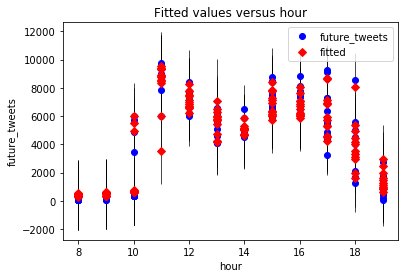

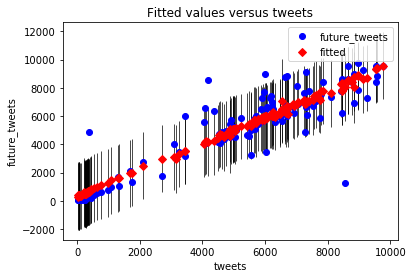

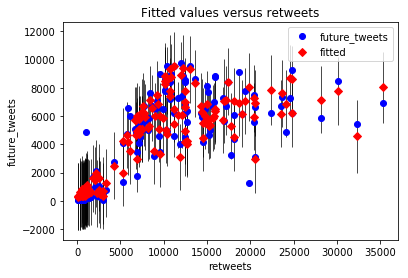

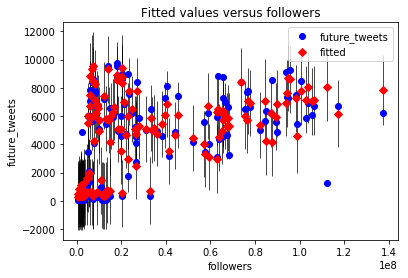

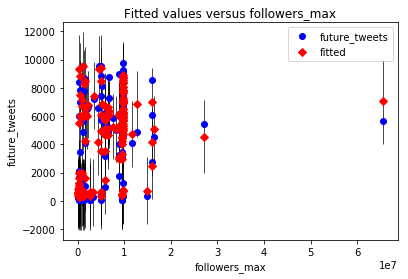

============================= SB49 After Feb. 1, 8:00 p.m.: 1-hour window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     102.1
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           6.05e-43
Time:                        22:48:20   Log-Likelihood:                -940.87
No. Observations:                 134   AIC:                             1894.
Df Residuals:                     128   BIC:                             1911.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------

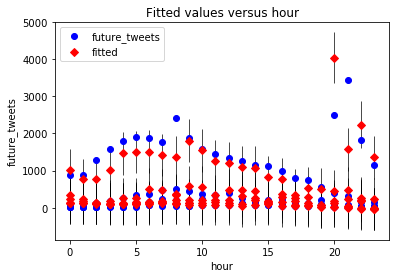

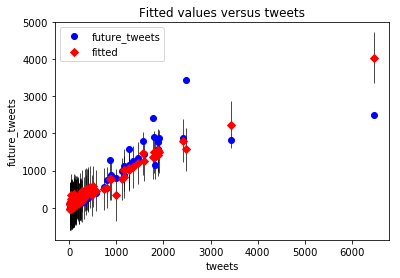

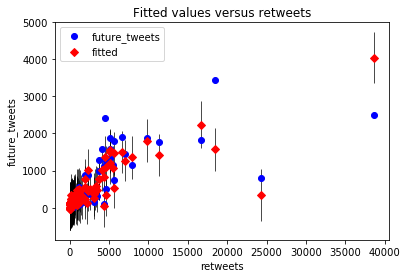

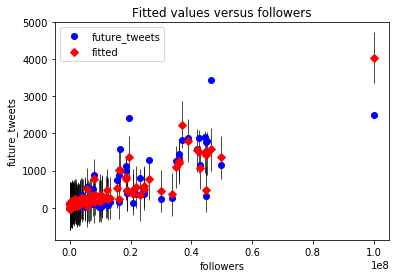

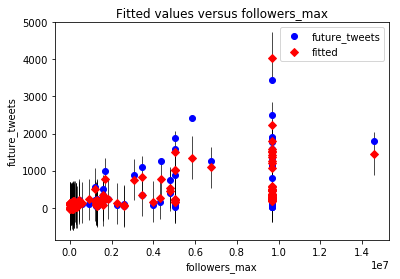

In [55]:
sb49_pre_active, sb49_active, sb49_post_active, sb49_pre_active_agg, sb49_active_agg, sb49_post_active_agg = split_three_time_periods_and_train_ols(sb49,title='SB49')

============================= Superbowl Before Feb. 1, 8:00 a.m.: 1-hour window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     58.26
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           2.63e-46
Time:                        22:52:08   Log-Likelihood:                -3510.1
No. Observations:                 439   AIC:                             7032.
Df Residuals:                     433   BIC:                             7057.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------

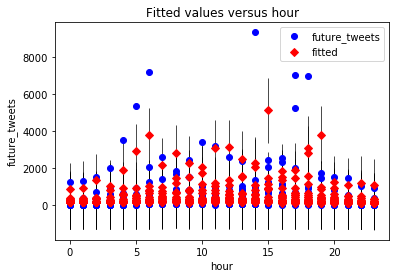

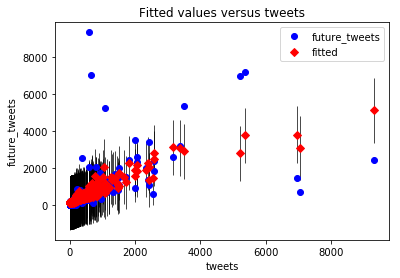

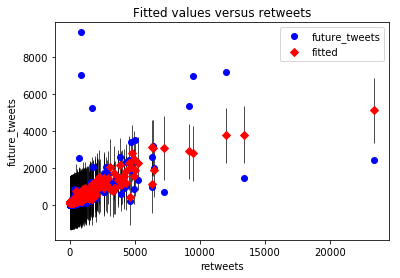

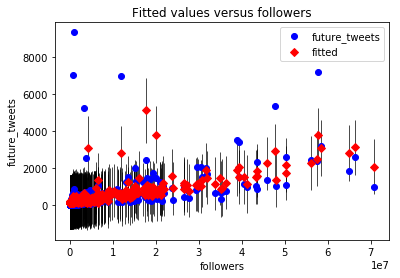

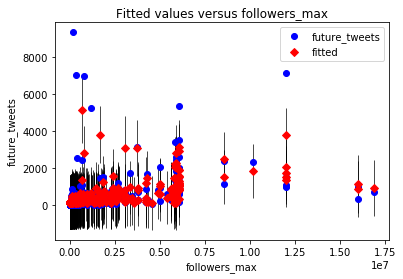

============================= Superbowl Between Feb. 1, 8:00 a.m. and 8:00 p.m.: 5-minute window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     222.1
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           7.17e-64
Time:                        22:52:10   Log-Likelihood:                -1328.4
No. Observations:                 143   AIC:                             2669.
Df Residuals:                     137   BIC:                             2687.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025     

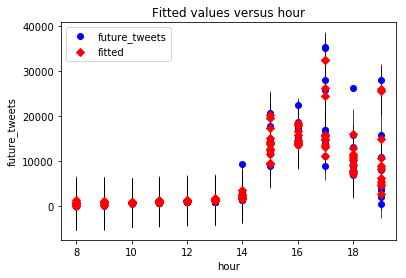

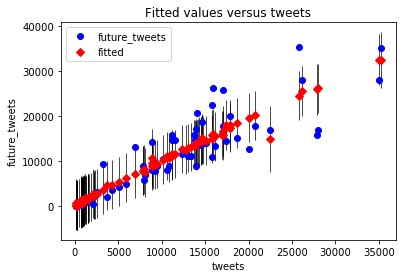

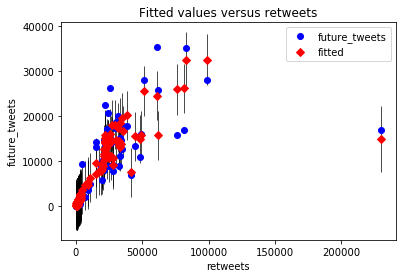

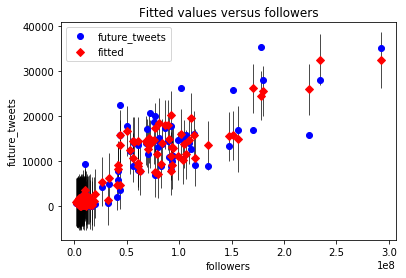

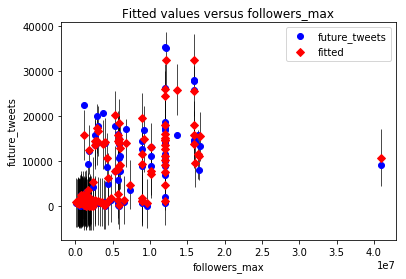

============================= Superbowl After Feb. 1, 8:00 p.m.: 1-hour window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     136.2
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           1.72e-49
Time:                        22:52:11   Log-Likelihood:                -969.42
No. Observations:                 134   AIC:                             1951.
Df Residuals:                     128   BIC:                             1968.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------

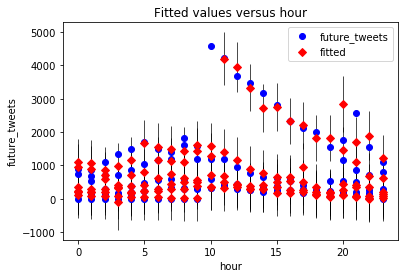

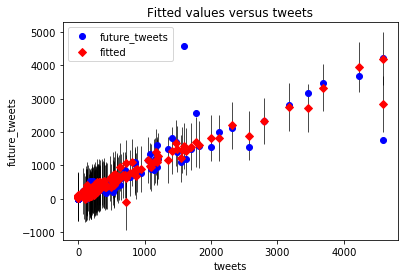

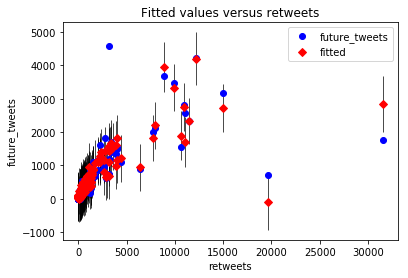

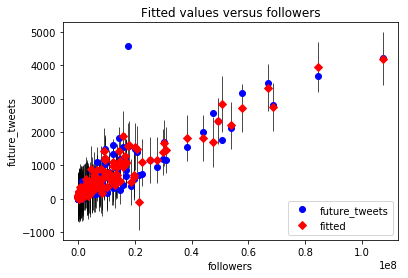

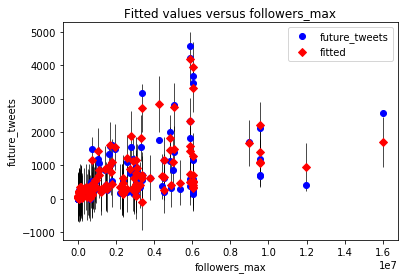

In [64]:
superbowl_pre_active, superbowl_active, superbowl_post_active, superbowl_pre_active_agg, superbowl_active_agg, superbowl_post_active_agg = split_three_time_periods_and_train_ols(superbowl,title='Superbowl')

In [16]:
# QUESTION 7: Also, aggregate the data of all hashtags, and train 3 models (for the intervals
# mentioned above) to predict the number of tweets in the next hour on the aggregated data.
# Perform the same evaluations on your combined model and compare with models you trained for
# individual hashtags.

In [56]:
full_df = pd.concat([gohawks, gopatriots, nfl, patriots, sb49, superbowl])

============================= Combined Datasets Before Feb. 1, 8:00 a.m.: 1-hour window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     60.10
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           1.76e-47
Time:                        22:58:30   Log-Likelihood:                -3982.0
No. Observations:                 439   AIC:                             7976.
Df Residuals:                     433   BIC:                             8000.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-

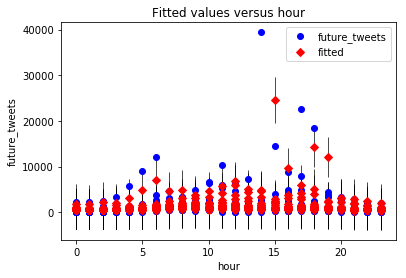

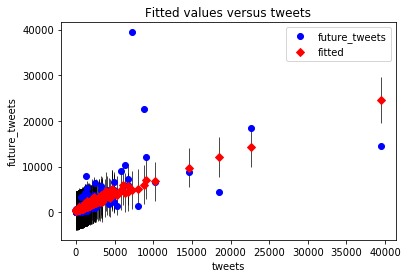

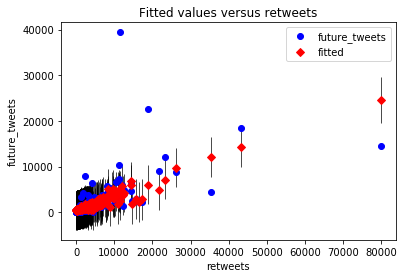

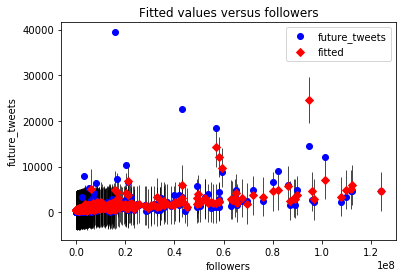

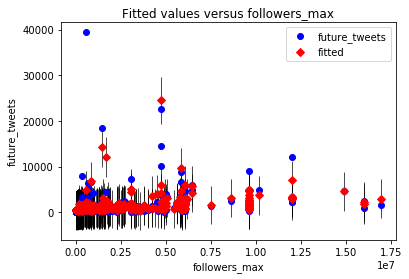

============================= Combined Datasets Between Feb. 1, 8:00 a.m. and 8:00 p.m.: 5-minute window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     152.3
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           3.86e-54
Time:                        22:58:32   Log-Likelihood:                -1394.8
No. Observations:                 143   AIC:                             2802.
Df Residuals:                     137   BIC:                             2819.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.

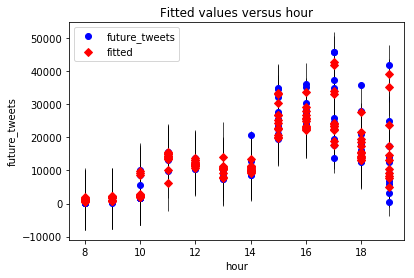

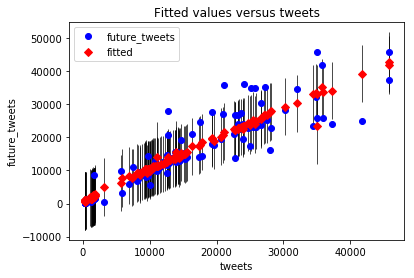

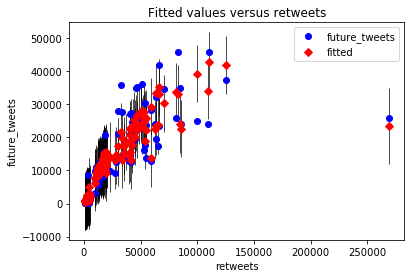

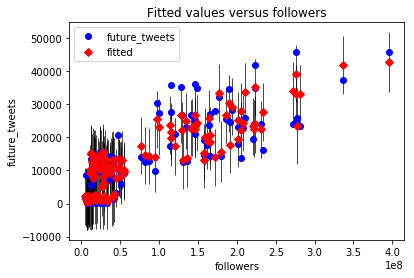

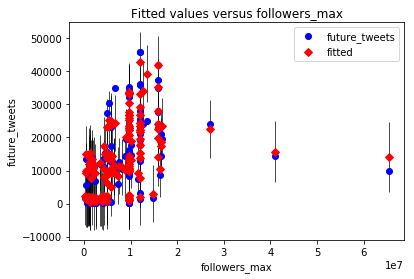

============================= Combined Datasets After Feb. 1, 8:00 p.m.: 1-hour window ======================================
                            OLS Regression Results                            
Dep. Variable:          future_tweets   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     158.9
Date:                Tue, 05 Jun 2018   Prob (F-statistic):           4.04e-53
Time:                        22:58:34   Log-Likelihood:                -1061.7
No. Observations:                 134   AIC:                             2135.
Df Residuals:                     128   BIC:                             2153.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--

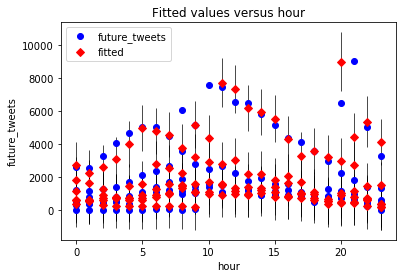

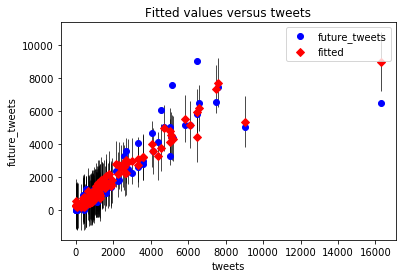

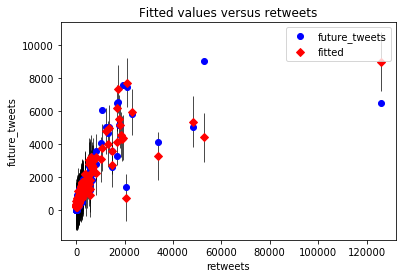

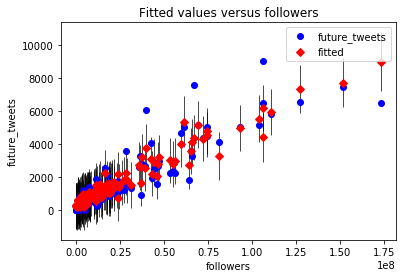

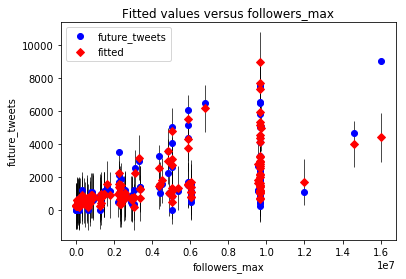

In [85]:
full_df_pre_active, full_df_active, full_df_post_active, full_df_pre_active_agg, full_df_active_agg, full_df_post_active_agg = split_three_time_periods_and_train_ols(full_df,title='Combined Datasets')

In [98]:
pre_active_next_hour = full_df_pre_active_agg.index[-1:]
pre_active_next_hour = pre_active_next_hour.shift(1, freq='60T')
pre_active_next_hour

DatetimeIndex(['2015-02-01 08:00:00-08:00'], dtype='datetime64[ns, America/Los_Angeles]', name='citation_date_pst', freq='60T')

In [100]:
full_df_pre_active.predict(pd.DataFrame({
  'citation_date_pst': pre_active_next_hour, # next hour
    'tweets': 0,
    'hour': 9,
    'retweets': 0,
    'followers': 0,
    'followers_max': 0}, index=[0]))

0    438.59507
dtype: float64

In [107]:
active_next_hour = full_df_active_agg.index[-1:]
active_next_hour = active_next_hour.shift(1, freq='5T')
active_next_hour

DatetimeIndex(['2015-02-01 20:00:00-08:00'], dtype='datetime64[ns, America/Los_Angeles]', name='citation_date_pst', freq='5T')

In [108]:
full_df_active.predict(pd.DataFrame({
  'citation_date_pst': active_next_hour, # next 5 min
    'tweets': 0,
    'hour': 20,
    'retweets': 0,
    'followers': 0,
    'followers_max': 0}, index=[0]))

0    1940.810727
dtype: float64

In [109]:
post_active_next_hour = full_df_post_active_agg.index[-1:]
post_active_next_hour = post_active_next_hour.shift(1, freq='60T')
post_active_next_hour

DatetimeIndex(['2015-02-07 11:00:00-08:00'], dtype='datetime64[ns, America/Los_Angeles]', name='citation_date_pst', freq='60T')

In [110]:
full_df_post_active.predict(pd.DataFrame({
  'citation_date_pst': post_active_next_hour, # next hour
    'tweets': 0,
    'hour': 11,
    'retweets': 0,
    'followers': 0,
    'followers_max': 0}, index=[0]))

0    111.262061
dtype: float64

In [ ]:
# QUESTION 8: Use grid search to find the best parameter set for RandomForestRegressor and
# GradientBoostingRegressor respectively. Use the following param grid
# {
# 'max_depth': [10, 20, 40, 60, 80, 100, 200, None],
# 'max_features': ['auto', 'sqrt'],
# 'min_samples_leaf': [1, 2, 4],
# 'min_samples_split': [2, 5, 10],
# 'n_estimators': [200, 400, 600, 800, 1000,
# 1200, 1400, 1600, 1800, 2000]
# }
# Set cv = KFold(5, shuffle=True), scoring='neg mean squared error' for the grid search.
# Analyze the result of the grid search. Do the test errors from cross-validation look good? If not,
# please explain the reason.

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import warnings

In [111]:
def run_grid_search(df_agg):
    params = {
        'max_depth': [10, 20, 40, 60, 80, 100, 200, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
        }

    cv = KFold(5, shuffle=True)
    
    df_agg = df_agg.groupby(pd.Grouper(key='citation_date_pst',freq='60Min')).agg({
        'hour':'max',
        'tweets':'sum',
        'retweets':'sum',
        'followers':'sum',
        'followers_max':'max'
    })
    df_agg['future_tweets'] = df_agg['tweets']
    df_agg.future_tweets = df_agg.future_tweets.shift(-1)
    
    X = np.nan_to_num(df_agg[['hour','tweets','retweets','followers','followers_max']])
    y = np.nan_to_num(df_agg['future_tweets'])

    random_forest_grid = GridSearchCV(RandomForestRegressor(), params,
                                      n_jobs=-1, cv = cv, scoring='neg_mean_squared_error')

    random_forest_grid.fit(X,y)
    
    gradient_boosting_grid = GridSearchCV(GradientBoostingRegressor(), params,
                                      n_jobs=-1, cv = cv, scoring='neg_mean_squared_error')
    gradient_boosting_grid.fit(X,y)
    
    return random_forest_grid, gradient_boosting_grid

In [112]:
# gohawks_random_forest, gohawks_gradient_boosting = run_grid_search(gohawks)

In [113]:
# pickle.dump( gohawks_random_forest, open("gohawks_random_forest.pkl","wb"))
# pickle.dump( gohawks_gradient_boosting, open("gohawks_gradient_boosting.pkl","wb"))

In [ ]:
gohawks_random_forest = pickle.load(open("gohawks_random_forest.pkl","rb"))
gohawks_gradient_boosting = pickle.load(open("gohawks_gradient_boosting.pkl","rb"))

In [146]:

warnings.filterwarnings("ignore")

go_hawks_rf_results = pd.DataFrame(gohawks_random_forest.cv_results_)[['param_max_depth',
                                              'param_max_features',
                                              'param_min_samples_leaf',
                                              'param_min_samples_split',
                                              'param_n_estimators',
                                              'mean_train_score','mean_test_score']]

#optimized params
go_hawks_rf_results.loc[go_hawks_rf_results['mean_test_score'] == max(go_hawks_rf_results['mean_test_score'])]


,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
990,100,sqrt,1,2,200,-78138.058901,-471817.286692


In [147]:
warnings.filterwarnings("ignore")

go_hawks_gb_results = pd.DataFrame(gohawks_gradient_boosting.cv_results_)[['param_max_depth',
                                              'param_max_features',
                                              'param_min_samples_leaf',
                                              'param_min_samples_split',
                                              'param_n_estimators',
                                              'mean_train_score','mean_test_score']]

#max params
go_hawks_gb_results.loc[go_hawks_gb_results['mean_test_score'] == max(go_hawks_gb_results['mean_test_score'])]


,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
1203,200,sqrt,2,2,800,-12325.35504,-472547.686174


In [114]:
# gopatriots_random_forest, gopatriots_gradient_boosting = run_grid_search(gopatriots)

In [115]:
# pickle.dump( gopatriots_random_forest, open("gopatriots_random_forest.pkl","wb"))
# pickle.dump( gopatriots_gradient_boosting, open("gopatriots_gradient_boosting.pkl","wb"))

In [ ]:
gopatriots_random_forest = pickle.load(open("gopatriots_random_forest.pkl","rb"))
gopatriots_gradient_boosting = pickle.load(open("gopatriots_gradient_boosting.pkl","rb"))

In [149]:

warnings.filterwarnings("ignore")

gopatriots_rf_results = pd.DataFrame(gopatriots_random_forest.cv_results_)[['param_max_depth',
                                              'param_max_features',
                                              'param_min_samples_leaf',
                                              'param_min_samples_split',
                                              'param_n_estimators',
                                              'mean_train_score','mean_test_score']]

#max params
gopatriots_rf_results.loc[gopatriots_rf_results['mean_test_score'] == max(gopatriots_rf_results['mean_test_score'])]



,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
421,40,auto,4,2,400,-17894.237912,-38790.068255


In [150]:

warnings.filterwarnings("ignore")

gopatriots_rf_results = pd.DataFrame(gopatriots_gradient_boosting.cv_results_)[['param_max_depth',
                                              'param_max_features',
                                              'param_min_samples_leaf',
                                              'param_min_samples_split',
                                              'param_n_estimators',
                                              'mean_train_score','mean_test_score']]

#max params
gopatriots_rf_results.loc[gopatriots_rf_results['mean_test_score'] == max(gopatriots_rf_results['mean_test_score'])]



,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
706,60,sqrt,4,5,1400,-0.489615,-16727.13068


In [116]:
# nfl_random_forest, nfl_gradient_boosting = run_grid_search(nfl)

In [117]:
# pickle.dump( nfl_random_forest, open("nfl_random_forest.pkl","wb"))
# pickle.dump( nfl_gradient_boosting, open("nfl_gradient_boosting.pkl","wb"))

In [ ]:
nfl_random_forest = pickle.load(open("nfl_random_forest.pkl","rb"))
nfl_gradient_boosting = pickle.load(open("nfl_gradient_boosting.pkl","rb"))

In [152]:

warnings.filterwarnings("ignore")

nfl_rf_results = pd.DataFrame(nfl_random_forest.cv_results_)[['param_max_depth',
                                              'param_max_features',
                                              'param_min_samples_leaf',
                                              'param_min_samples_split',
                                              'param_n_estimators',
                                              'mean_train_score','mean_test_score']]

#max params
nfl_rf_results.loc[nfl_rf_results['mean_test_score'] == max(nfl_rf_results['mean_test_score'])]



,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
862,80,sqrt,2,10,600,-182808.670928,-251681.077766


In [153]:

warnings.filterwarnings("ignore")

nfl_gb_results = pd.DataFrame(nfl_gradient_boosting.cv_results_)[['param_max_depth',
                                              'param_max_features',
                                              'param_min_samples_leaf',
                                              'param_min_samples_split',
                                              'param_n_estimators',
                                              'mean_train_score','mean_test_score']]

#max params
nfl_gb_results.loc[nfl_gb_results['mean_test_score'] == max(nfl_gb_results['mean_test_score'])]


,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
141,10,sqrt,2,10,400,-8.307565,-279390.497395


In [118]:
# patriots_random_forest, patriots_gradient_boosting = run_grid_search(patriots)

In [119]:
# pickle.dump( patriots_random_forest, open("patriots_random_forest.pkl","wb"))
# pickle.dump( patriots_gradient_boosting, open("patriots_gradient_boosting.pkl","wb"))

In [ ]:
patriots_random_forest = pickle.load(open("patriots_random_forest.pkl","rb"))
patriots_gradient_boosting = pickle.load(open("patriots_gradient_boosting.pkl","rb"))

In [155]:

warnings.filterwarnings("ignore")

patriots_rf_results = pd.DataFrame(patriots_random_forest.cv_results_)[['param_max_depth',
                                              'param_max_features',
                                              'param_min_samples_leaf',
                                              'param_min_samples_split',
                                              'param_n_estimators',
                                              'mean_train_score','mean_test_score']]

#max params
patriots_rf_results.loc[patriots_rf_results['mean_test_score'] == max(patriots_rf_results['mean_test_score'])]


,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
181,20,auto,1,2,400,-898688.634664,-5.328324e+06


In [157]:

warnings.filterwarnings("ignore")

patriots_gb_results = pd.DataFrame(patriots_gradient_boosting.cv_results_)[['param_max_depth',
                                              'param_max_features',
                                              'param_min_samples_leaf',
                                              'param_min_samples_split',
                                              'param_n_estimators',
                                              'mean_train_score','mean_test_score']]

#max params
patriots_gb_results.loc[patriots_gb_results['mean_test_score'] == max(patriots_gb_results['mean_test_score'])]



,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
600,60,auto,4,2,200,-33390.997743,-4.420973e+06


In [120]:
# sb49_random_forest, sb49_gradient_boosting = run_grid_search(sb49)

In [121]:
# pickle.dump( sb49_random_forest, open("sb49_random_forest.pkl","wb"))
# pickle.dump( sb49_gradient_boosting, open("sb49_gradient_boosting.pkl","wb"))

In [ ]:
sb49_random_forest = pickle.load(open("sb49_random_forest.pkl","rb"))
sb49_gradient_boosting = pickle.load(open("sb49_gradient_boosting.pkl","rb"))

In [162]:

warnings.filterwarnings("ignore")

sb49_rf_results = pd.DataFrame(sb49_random_forest.cv_results_)[['param_max_depth',
                                              'param_max_features',
                                              'param_min_samples_leaf',
                                              'param_min_samples_split',
                                              'param_n_estimators',
                                              'mean_train_score','mean_test_score']]

#max params
sb49_rf_results.loc[sb49_rf_results['mean_test_score'] == max(sb49_rf_results['mean_test_score'])]




,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
70,10,auto,4,5,200,-1.132382e+07,-2.764427e+07


In [163]:

warnings.filterwarnings("ignore")

sb49_gb_results = pd.DataFrame(sb49_gradient_boosting.cv_results_)[['param_max_depth',
                                              'param_max_features',
                                              'param_min_samples_leaf',
                                              'param_min_samples_split',
                                              'param_n_estimators',
                                              'mean_train_score','mean_test_score']]

#max params
sb49_gb_results.loc[sb49_gb_results['mean_test_score'] == max(sb49_gb_results['mean_test_score'])]




,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
94,10,sqrt,1,2,1000,-0.217756,-2.662159e+07


In [122]:
# superbowl_random_forest, superbowl_gradient_boosting = run_grid_search(superbowl)

In [123]:
# pickle.dump( superbowl_random_forest, open("superbowl_random_forest.pkl","wb"))
# pickle.dump( superbowl_gradient_boosting, open("superbowl_gradient_boosting.pkl","wb"))

In [ ]:
superbowl_random_forest = pickle.load(open("superbowl_random_forest.pkl","rb"))
superbowl_gradient_boosting = pickle.load(open("superbowl_gradient_boosting.pkl","rb"))

In [164]:

warnings.filterwarnings("ignore")

superbowl_rf_results = pd.DataFrame(superbowl_random_forest.cv_results_)[['param_max_depth',
                                              'param_max_features',
                                              'param_min_samples_leaf',
                                              'param_min_samples_split',
                                              'param_n_estimators',
                                              'mean_train_score','mean_test_score']]

#max params
superbowl_rf_results.loc[superbowl_rf_results['mean_test_score'] == max(superbowl_rf_results['mean_test_score'])]



,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
60,10,auto,4,2,200,-6.850065e+07,-1.219276e+08


In [165]:

warnings.filterwarnings("ignore")

superbowl_gb_results = pd.DataFrame(superbowl_gradient_boosting.cv_results_)[['param_max_depth',
                                              'param_max_features',
                                              'param_min_samples_leaf',
                                              'param_min_samples_split',
                                              'param_n_estimators',
                                              'mean_train_score','mean_test_score']]

#max params
superbowl_gb_results.loc[superbowl_gb_results['mean_test_score'] == max(superbowl_gb_results['mean_test_score'])]




,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
13,10,auto,1,5,800,-9.922628e-08,-1.157875e+08


In [124]:
# full_df_random_forest, full_df_gradient_boosting = run_grid_search(full_df)

In [125]:
# pickle.dump( full_df_random_forest, open("full_df_random_forest.pkl","wb"))
# pickle.dump( full_df_gradient_boosting, open("full_df_gradient_boosting.pkl","wb"))

In [ ]:
full_df_random_forest = pickle.load(open("full_df_random_forest.pkl","rb"))
full_df_gradient_boosting = pickle.load(open("full_df_gradient_boosting.pkl","rb"))

In [167]:

warnings.filterwarnings("ignore")

full_df_rf_results = pd.DataFrame(full_df_random_forest.cv_results_)[['param_max_depth',
                                              'param_max_features',
                                              'param_min_samples_leaf',
                                              'param_min_samples_split',
                                              'param_n_estimators',
                                              'mean_train_score','mean_test_score']]

#max params
full_df_rf_results.loc[full_df_rf_results['mean_test_score'] == max(full_df_rf_results['mean_test_score'])]



,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
820,80,sqrt,1,5,200,-9.877613e+07,-1.987897e+08


In [168]:

warnings.filterwarnings("ignore")

full_df_gb_results = pd.DataFrame(full_df_gradient_boosting.cv_results_)[['param_max_depth',
                                              'param_max_features',
                                              'param_min_samples_leaf',
                                              'param_min_samples_split',
                                              'param_n_estimators',
                                              'mean_train_score','mean_test_score']]

#max params
full_df_gb_results.loc[full_df_gb_results['mean_test_score'] == max(full_df_gb_results['mean_test_score'])]



,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
1397,None,sqrt,2,5,1600,-0.000202,-3.160692e+08


In [ ]:
# QUESTION 9: Compare the best estimator you found in the grid search with OLS on the entire
# dataset.

In [171]:
def aggregate_df(df):
    df_agg = df.groupby(pd.Grouper(key='citation_date_pst',freq='60Min')).agg({
        'hour':'max',
        'tweets':'sum',
        'retweets':'sum',
        'followers':'sum',
        'followers_max':'max'
    })
    df_agg['future_tweets'] = df_agg['tweets']
    df_agg.future_tweets = df_agg.future_tweets.shift(-1)
    
    X = np.nan_to_num(df_agg[['hour','tweets','retweets','followers','followers_max']])
    y = np.nan_to_num(df_agg['future_tweets'])
    
    return X, y

In [173]:
gohawks_X, gohawks_y = aggregate_df(gohawks)
gopatriots_X, gopatriots_y = aggregate_df(gopatriots)
nfl_X, nfl_y = aggregate_df(nfl)
patriots_X, patriots_y = aggregate_df(patriots)
sb49_X, sb49_y = aggregate_df(sb49)
superbowl_X, superbowl_y = aggregate_df(superbowl)

In [187]:
gohawks_opt_rf = RandomForestRegressor(max_depth=100,
                                       max_features='sqrt',
                                       min_samples_leaf=1,
                                       min_samples_split=2,
                                       n_estimators=200)
gohawks_opt_rf.fit(gohawks_X,gohawks_y)

gohawks_opt_gb = GradientBoostingRegressor(max_depth=200,
                                           max_features='sqrt',
                                           min_samples_leaf=2,
                                           min_samples_split=2,
                                           n_estimators=800)
gohawks_opt_gb.fit(gohawks_X,gohawks_y)

print('#Gohawks Random Forest R^2:',gohawks_opt_rf.score(gohawks_X,gohawks_y))
print('#Gohawks Random Forest R^2:',gohawks_opt_gb.score(gohawks_X,gohawks_y))




#Gohawks Random Forest R^2: 0.941607879117
#Gohawks Random Forest R^2: 0.98863622623


In [189]:
gopatriots_opt_rf = RandomForestRegressor(max_depth=40,
                                       max_features='auto',
                                       min_samples_leaf=4,
                                       min_samples_split=2,
                                       n_estimators=400)
gopatriots_opt_rf.fit(gopatriots_X,gopatriots_y)

gopatriots_opt_gb = GradientBoostingRegressor(max_depth=60,
                                           max_features='sqrt',
                                           min_samples_leaf=4,
                                           min_samples_split=5,
                                           n_estimators=1400)
gopatriots_opt_gb.fit(gopatriots_X,gopatriots_y)

print('#GoPatriots Random Forest R^2:',gopatriots_opt_rf.score(gopatriots_X,gopatriots_y))
print('#GoPatriots Random Forest R^2:',gopatriots_opt_gb.score(gopatriots_X,gopatriots_y))




#GoPatriots Random Forest R^2: 0.779898707535
#GoPatriots Random Forest R^2: 0.999993491768


In [190]:
nfl_opt_rf = RandomForestRegressor(max_depth=80,
                                       max_features='sqrt',
                                       min_samples_leaf=2,
                                       min_samples_split=10,
                                       n_estimators=600)
nfl_opt_rf.fit(nfl_X,nfl_y)

nfl_opt_gb = GradientBoostingRegressor(max_depth=10,
                                           max_features='sqrt',
                                           min_samples_leaf=2,
                                           min_samples_split=10,
                                           n_estimators=400)
nfl_opt_gb.fit(nfl_X,nfl_y)

print('#GoPatriots Random Forest R^2:',nfl_opt_rf.score(nfl_X,nfl_y))
print('#GoPatriots Random Forest R^2:',nfl_opt_gb.score(nfl_X,nfl_y))




#GoPatriots Random Forest R^2: 0.706554416822
#GoPatriots Random Forest R^2: 0.999998538495


In [191]:
patriots_opt_rf = RandomForestRegressor(max_depth=20,
                                       max_features='auto',
                                       min_samples_leaf=1,
                                       min_samples_split=2,
                                       n_estimators=400)
patriots_opt_rf.fit(patriots_X,patriots_y)

patriots_opt_gb = GradientBoostingRegressor(max_depth=60,
                                           max_features='auto',
                                           min_samples_leaf=4,
                                           min_samples_split=2,
                                           n_estimators=200)
patriots_opt_gb.fit(patriots_X,patriots_y)

print('#Patriots Random Forest R^2:',nfl_opt_rf.score(patriots_X,patriots_y))
print('#Patriots Random Forest R^2:',nfl_opt_gb.score(patriots_X,patriots_y))




#Patriots Random Forest R^2: 0.277198401647
#Patriots Random Forest R^2: 0.161839703466


In [193]:
sb49_opt_rf = RandomForestRegressor(max_depth=10,
                                       max_features='auto',
                                       min_samples_leaf=4,
                                       min_samples_split=5,
                                       n_estimators=200)
sb49_opt_rf.fit(patriots_X,patriots_y)

sb49_opt_gb = GradientBoostingRegressor(max_depth=10,
                                           max_features='sqrt',
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           n_estimators=1000)
sb49_opt_gb.fit(sb49_X,sb49_y)

print('#sb49 Random Forest R^2:',sb49_opt_rf.score(sb49_X,sb49_y))
print('#sb49 Random Forest R^2:',sb49_opt_gb.score(sb49_X,sb49_y))




#sb49 Random Forest R^2: 0.523625386533
#sb49 Random Forest R^2: 0.999999997353


In [194]:
superbowl_opt_rf = RandomForestRegressor(max_depth=10,
                                       max_features='auto',
                                       min_samples_leaf=4,
                                       min_samples_split=2,
                                       n_estimators=200)
superbowl_opt_rf.fit(patriots_X,patriots_y)

superbowl_opt_gb = GradientBoostingRegressor(max_depth=10,
                                           max_features='auto',
                                           min_samples_leaf=1,
                                           min_samples_split=5,
                                           n_estimators=800)
superbowl_opt_gb.fit(sb49_X,sb49_y)

print('#superbowl Random Forest R^2:',superbowl_opt_rf.score(sb49_X,sb49_y))
print('#superbowl Random Forest R^2:',superbowl_opt_gb.score(sb49_X,sb49_y))




#superbowl Random Forest R^2: 0.523810337529
#superbowl Random Forest R^2: 0.999999997353


In [ ]:
# QUESTION 10: For each time period described in Question 6, perform the same grid search
# above for GradientBoostingRegressor (with corresponding time window length). Does the cross-
# validation test error change? Are the best parameter set you find in each period agree with those
# you found above?

In [34]:
full_df.head()

,citation_date_raw,author_nick_names,tweets,retweets,followers,followers_max
0,1421518778,rejinseattle,1,5,1752.0,1752.0
1,1421259536,emq4444,1,2,258.0,258.0
2,1421468519,beccadelgado67,1,5,22.0,22.0
3,1421468497,beccadelgado67,1,2,22.0,22.0
4,1421468336,beccadelgado67,1,2,22.0,22.0


In [ ]:
# QUESTION 11: Now try to regress the aggregated data with MLPRegressor. Try different
# architectures (i.e. the structure of the network) by adjusting hidden layer sizes. You should try
# at least 5 architectures with various numbers of layers and layer sizes. Report the architectures you
# tried, as well as its MSE of fitting the entire aggregated data.

In [40]:
full_df_agg = full_df.groupby(pd.Grouper(key='citation_date_pst', freq='60Min')).agg(
        {'hour':'max',
         'tweets':'sum',
         'retweets':'sum',
         'followers':'sum',
         'followers_max':'max'})
full_df_agg['future_tweets'] = full_df_agg['tweets']
full_df_agg.future_tweets = full_df_agg.future_tweets.shift(-1)

In [41]:
full_df_agg.head()

,hour,tweets,retweets,followers,followers_max,future_tweets
citation_date_pst,,,,,,
2015-01-14 00:00:00-08:00,0,111,714,223405.0,41818.0,89.0
2015-01-14 01:00:00-08:00,1,89,663,187317.0,19558.0,110.0
2015-01-14 02:00:00-08:00,2,110,640,1657090.0,1362401.0,100.0
2015-01-14 03:00:00-08:00,3,100,267,165256.0,19558.0,137.0
2015-01-14 04:00:00-08:00,4,137,468,444858.0,65150.0,169.0


In [44]:
full_df_agg_future_tweets = full_df_agg['future_tweets'].values
full_df_agg_future_tweets[-1] = full_df_agg_future_tweets[-2]
full_df_agg_input = full_df_agg.drop(['future_tweets'], axis=1)
full_df_agg_input = full_df_agg_input.values

In [45]:
full_df_agg_future_tweets[-1] = full_df_agg_future_tweets[-2]

In [46]:
def regress_with_nn(layers, x, y, best_layer, best_mse):
    print("\n===== " + str(len(layers)) + " Layer(s) of " + str(layers) + " =====")
    if(len(layers) == 1):
        nn = MLPRegressor(hidden_layer_sizes=(layers[0], ))
    elif(len(layers) == 2):
        nn = MLPRegressor(hidden_layer_sizes=(layers[0],layers[1], ))
    nn.fit(x, y)
    ypred = nn.predict(x)
    print("MSE value: ", mean_squared_error(y, ypred)) 
    
    if(best_mse > mean_squared_error(y, ypred)):
        best_layer = layers
        best_mse = mean_squared_error(y, ypred)
    
    return best_layer, best_mse

In [47]:
best_architecture_layers = []
best_architecture_mse = 9223372036854775807

In [52]:
best_architecture_layers, best_architecture_mse = regress_with_nn([100], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)
best_architecture_layers, best_architecture_mse = regress_with_nn([50], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)
best_architecture_layers, best_architecture_mse = regress_with_nn([10], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)
best_architecture_layers, best_architecture_mse = regress_with_nn([5], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)

best_architecture_layers, best_architecture_mse = regress_with_nn([100,100], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)
best_architecture_layers, best_architecture_mse = regress_with_nn([100,10], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)
best_architecture_layers, best_architecture_mse = regress_with_nn([100,50], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)
best_architecture_layers, best_architecture_mse = regress_with_nn([100,10], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)

best_architecture_layers, best_architecture_mse = regress_with_nn([50,100], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)
best_architecture_layers, best_architecture_mse = regress_with_nn([50,10], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)
best_architecture_layers, best_architecture_mse = regress_with_nn([50,50], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)
best_architecture_layers, best_architecture_mse = regress_with_nn([50,10], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)

best_architecture_layers, best_architecture_mse = regress_with_nn([10,100], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)
best_architecture_layers, best_architecture_mse = regress_with_nn([10,10], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)
best_architecture_layers, best_architecture_mse = regress_with_nn([10,50], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)
best_architecture_layers, best_architecture_mse = regress_with_nn([10,10], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)

best_architecture_layers, best_architecture_mse = regress_with_nn([5,100], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)
best_architecture_layers, best_architecture_mse = regress_with_nn([5,10], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)
best_architecture_layers, best_architecture_mse = regress_with_nn([5,50], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)
best_architecture_layers, best_architecture_mse = regress_with_nn([5,10], full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)


===== 1 Layer(s) of [100] =====
MSE value:  3.04869082025e+13

===== 1 Layer(s) of [50] =====
MSE value:  20779995722.6

===== 1 Layer(s) of [10] =====
MSE value:  26240381997.5

===== 1 Layer(s) of [5] =====


/Users/nnguyen/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MSE value:  1.48011615479e+12

===== 2 Layer(s) of [100, 100] =====
MSE value:  555822917391.0

===== 2 Layer(s) of [100, 10] =====
MSE value:  729096554751.0

===== 2 Layer(s) of [100, 50] =====
MSE value:  3026928195.55

===== 2 Layer(s) of [100, 10] =====
MSE value:  2.16511230245e+12

===== 2 Layer(s) of [50, 100] =====
MSE value:  3.66447668386e+13

===== 2 Layer(s) of [50, 10] =====
MSE value:  3.66254849496e+12

===== 2 Layer(s) of [50, 50] =====
MSE value:  1.74839625813e+13

===== 2 Layer(s) of [50, 10] =====
MSE value:  5.72087865837e+12

===== 2 Layer(s) of [10, 100] =====
MSE value:  1.75681198716e+13

===== 2 Layer(s) of [10, 10] =====
MSE value:  1.81624292493e+12

===== 2 Layer(s) of [10, 50] =====
MSE value:  1.4966065337e+13

===== 2 Layer(s) of [10, 10] =====
MSE value:  339815624.817

===== 2 Layer(s) of [5, 100] =====
MSE value:  851587436.12

===== 2 Layer(s) of [5, 10] =====
MSE value:  302778685.894

===== 2 Layer(s) of [5, 50] =====
MSE value:  819380946.154

==

In [ ]:
# QUESTION 12: Use StandardScaler to scale the data before feeding it to MLPRegressor
# (with the best architecture you got above). Does its performance increase?

In [53]:
scaler = StandardScaler()
scaler.fit(full_df_agg_input)
full_df_agg_input = scaler.transform(full_df_agg_input)
regress_with_nn(best_architecture_layers, full_df_agg_input, full_df_agg_future_tweets, best_architecture_layers, best_architecture_mse)


===== 2 Layer(s) of [5, 10] =====
MSE value:  816273346.404


/Users/nnguyen/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


([5, 10], 302778685.89364731)

In [ ]:
# QUESTION 13: Using grid search, find the best architecture for each period (with corre-
# sponding window length) described in Question 6.

In [ ]:
# QUESTION 14: Report the model you use. For each test file, provide your predictions on the
# number of tweets in the next time window.
# Note: Test data should not be used as a source for training. You are not bounded to only linear
# models. You can find your best model through cross validation of your training data.

In [ ]:
# QUESTION 15:
# 1. Explain the method you use to determine whether the location is in Washington, Massachusetts
# or neither. Only use the tweets whose authors belong to either Washington or Massachusetts
# for the next part.
# 2. Train a binary classifier to predict the location of the author of a tweet (Washington or
# Massachusetts), given only the textual content of the tweet (using the techniques you learnt
# in project 1). Try different classification algorithms (at least 3). For each, plot ROC curve,
# report confusion matrix, and calculate accuracy, recall and precision.

# Generate Location-Based Dataset

In [70]:
DATA_DIRECTORY = "ECE219_tweet_data/"
filenames = ["tweets_#superbowl.txt"]

MASSACHUSETTS_FLAGS = ["Massachusetts","Boston","MA"]
WASHINGTON_FLAGS = ["Washington","Seattle","WA"]

tweetLocationDataset = []

with open(DATA_DIRECTORY+filenames[0]) as f:
    for line in f:
        json_tweet = json.loads(line)
        location = json_tweet['tweet']['user']['location']
        locationFoundFlag = False
        for m in MASSACHUSETTS_FLAGS:
            if m in location:
                locationFoundFlag = True
                tweetLocationDataset.append((json_tweet['tweet']['text'],"MA"))
                break
        if not locationFoundFlag:
            for w in WASHINGTON_FLAGS:
                if w in location:
                    locationFoundFlag = True
                    tweetLocationDataset.append((json_tweet['tweet']['text'],"WA"))
                                        
with open('locationBasedDataset.pickle', 'wb') as handle:
    pickle.dump(tweetLocationDataset, handle)


# Load Data If Already Generated

In [76]:
with open('locationBasedDataset.pickle','rb') as handle:
    tweetLocationDataset = pickle.load(handle)
    
data = np.array(tweetLocationDataset)

# Pre-Process Tweets

In [77]:
print("Number of Massachusetts tweets: %d" % sum(data[:,1] == "MA"))
print("Number of Washington tweets:    %d" % sum(data[:,1] == "WA"))

clean_data = set()

for i in range(len(data)):
    tweet = data[i,0]
    clean_data.add((clean_tweet(tweet),data[i,1]))
clean_data = list(clean_data)
clean_data = np.array(clean_data)
np.random.shuffle(clean_data)
    
print("\nNumber of Unique Massachusetts tweets: %d" % sum(clean_data[:,1] == "MA"))
print("Number of Unique Washington tweets:    %d" % sum(clean_data[:,1] == "WA"))

print("\nCleaned Data Samples With Labels\n")
for i in range(100):
    print("Location " + clean_data[i,1] + ": " + clean_data[i,0])

Number of Massachusetts tweets: 21195
Number of Washington tweets:    32441

Number of Unique Massachusetts tweets: 20186
Number of Unique Washington tweets:    25502

Cleaned Data Samples With Labels

Location WA: 5th tv spot pitch perfect 2 superbowlxlix
Location MA: 107 patriots superbowlxlix halftime
Location WA: ive got 00 superbowl squares come
Location MA: please please please john travolta introduce idina manzell superbowlxlix
Location WA: 12thgear rt bring bike back superbowlxlix
Location MA: superbowl stir gotta stir stir stir sauce italian grammi serifina
Location WA: much money glue superbowl loctite
Location WA: want healthy alternative usual game day snacks superbowlxlix try healthy
Location MA: would much rather seen missy elliott superbowl
Location MA: well damn superbowl
Location WA: two minutes superbowl
Location WA: pats fan 50 years superbowlxlix 2d patriots game ibe dad took 1st fenway 1963
Location WA: never doubted number1 gohawks seahawks superbowl screaming ama

In [78]:
SPLIT_TRAIN_RATIO = 0.8
splitIndex = int(clean_data.shape[0]*SPLIT_TRAIN_RATIO)

vectorizer = TfidfVectorizer(min_df=15)
vectorized_tweets_train = vectorizer.fit_transform(clean_data[:splitIndex,0])
vectorized_tweets_test = vectorizer.transform(clean_data[splitIndex:,0])
binarized_labels = clean_data[:,1].copy()
for n,label in enumerate(binarized_labels):
    if label == "MA":
        binarized_labels[n] = 0
    else:
        binarized_labels[n] = 1
        
y_train = binarized_labels[:splitIndex].astype('int')
y_test = binarized_labels[splitIndex:].astype('int')
print("Vectorized Tweets Train shape: " + str(vectorized_tweets_train.shape))

Vectorized Tweets Train shape: (36550, 2055)


In [79]:
x_train = vectorized_tweets_train
x_test = vectorized_tweets_test

Accuracy: 0.719413438389
Precision: 0.725214949991
Recall: 0.805496004677
F-1 Score: 0.76325023084


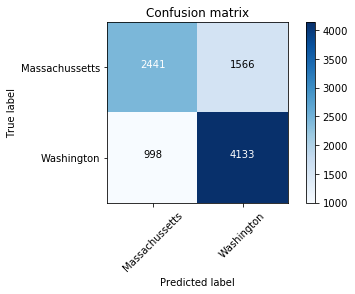

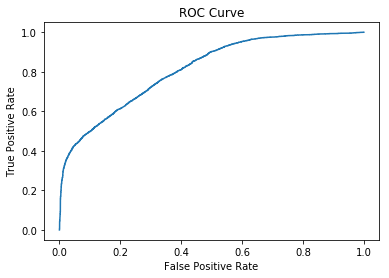

In [80]:
LogisticRegressionClassifier = LogisticRegression()
LogisticRegressionClassifier.fit(x_train,y_train)
train_predictions = LogisticRegressionClassifier.predict(x_train)
test_predictions = LogisticRegressionClassifier.predict(x_test)

print_metrics(y_test,test_predictions)
plot_confusion_matrix(confusion_matrix(y_test,test_predictions))
roc_plotter(LogisticRegressionClassifier,x_test,y_test,clfType="LogisticRegression")

Accuracy: 0.715364412344
Precision: 0.680559520411
Recall: 0.929253556812
F-1 Score: 0.785696630139


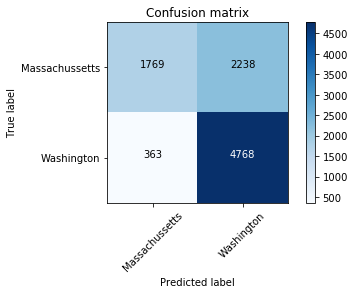

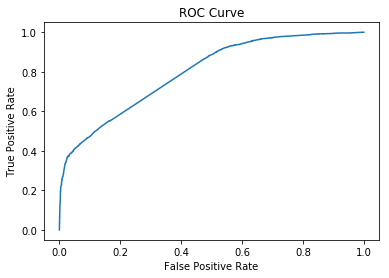

In [81]:
rfc = RandomForestClassifier(max_depth=30)
rfc.fit(x_train,y_train)
train_predictions = rfc.predict(x_train)
test_predictions = rfc.predict(x_test)

print_metrics(y_test,test_predictions)
plot_confusion_matrix(confusion_matrix(y_test,test_predictions))
roc_plotter(rfc,x_test,y_test,clfType="RandomForest")

Accuracy: 0.621689647625
Precision: 0.738461538462
Recall: 0.505164685247
F-1 Score: 0.599930563592


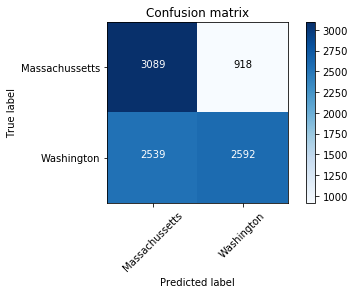

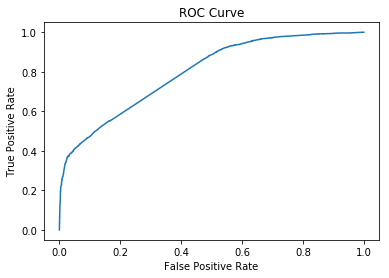

In [82]:
nb = GaussianNB()
nb.fit(x_train.toarray(),y_train)
train_predictions = nb.predict(x_train.toarray())
test_predictions = nb.predict(x_test.toarray())

print_metrics(y_test,test_predictions)
plot_confusion_matrix(confusion_matrix(y_test,test_predictions))
roc_plotter(rfc,x_test,y_test,clfType="NaiveBayes")

In [ ]:
# QUESTION 16: The dataset in hands is rich as there is a lot of metadata to each tweet. Be
# creative and propose a new problem (something interesting that can be inferred from this dataset)
# other than the previous parts. You can look into the literature of Twitter data analysis to get some
# ideas. Implement your idea and show that it works. As a suggestion, you might provide some
# analysis based on changes of tweet sentiments for fans of the opponent teams participating in the
# match. You get full credit for briniging in novelty and full or partial implementation of your new
# ideas.